In [1]:
import pandas as pd
import numpy as np
import os
import glob
import geopandas
import matplotlib.pyplot as plt
import time
from shapely.geometry import Point, Polygon

%matplotlib inline
width = 50
height = 50
plt.rcParams['figure.figsize'] = [width, height]

pd.options.display.max_columns = None

## Check if geopandas is installed
## import sys
## 'geopandas' in sys.modules

# Merge ICS 209 Plus Dataset to MTBS
# Assign ICS fires (not complexes) to appropriate MTBS perimeter
# Match ICS complex fires to MTBS perimeters

## Set Directory
path = '/data/yoder/DensityProject/'
os.chdir(path)
# os.listdir()

In [2]:
begining = time.time()

In [3]:
# Load map of US
USMAP = geopandas.read_file(path + '/cb_2018_us_state_500k.shp')

In [4]:
# Read in MTBS Data
MTBS = geopandas.read_file(path + '/mtbs_perimeter_data/mtbs_perims_DD.shp')

In [5]:
## Check CRS
print(USMAP.crs == MTBS.crs)
USMAP.crs

True


<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
# Create set of the 11 Western United States
West = ['WA', 'OR', 'CA', 'NV','AZ','NM', 'UT','CO','WY','ID','MT']
WestStates = USMAP[USMAP['STUSPS'].isin(West)]

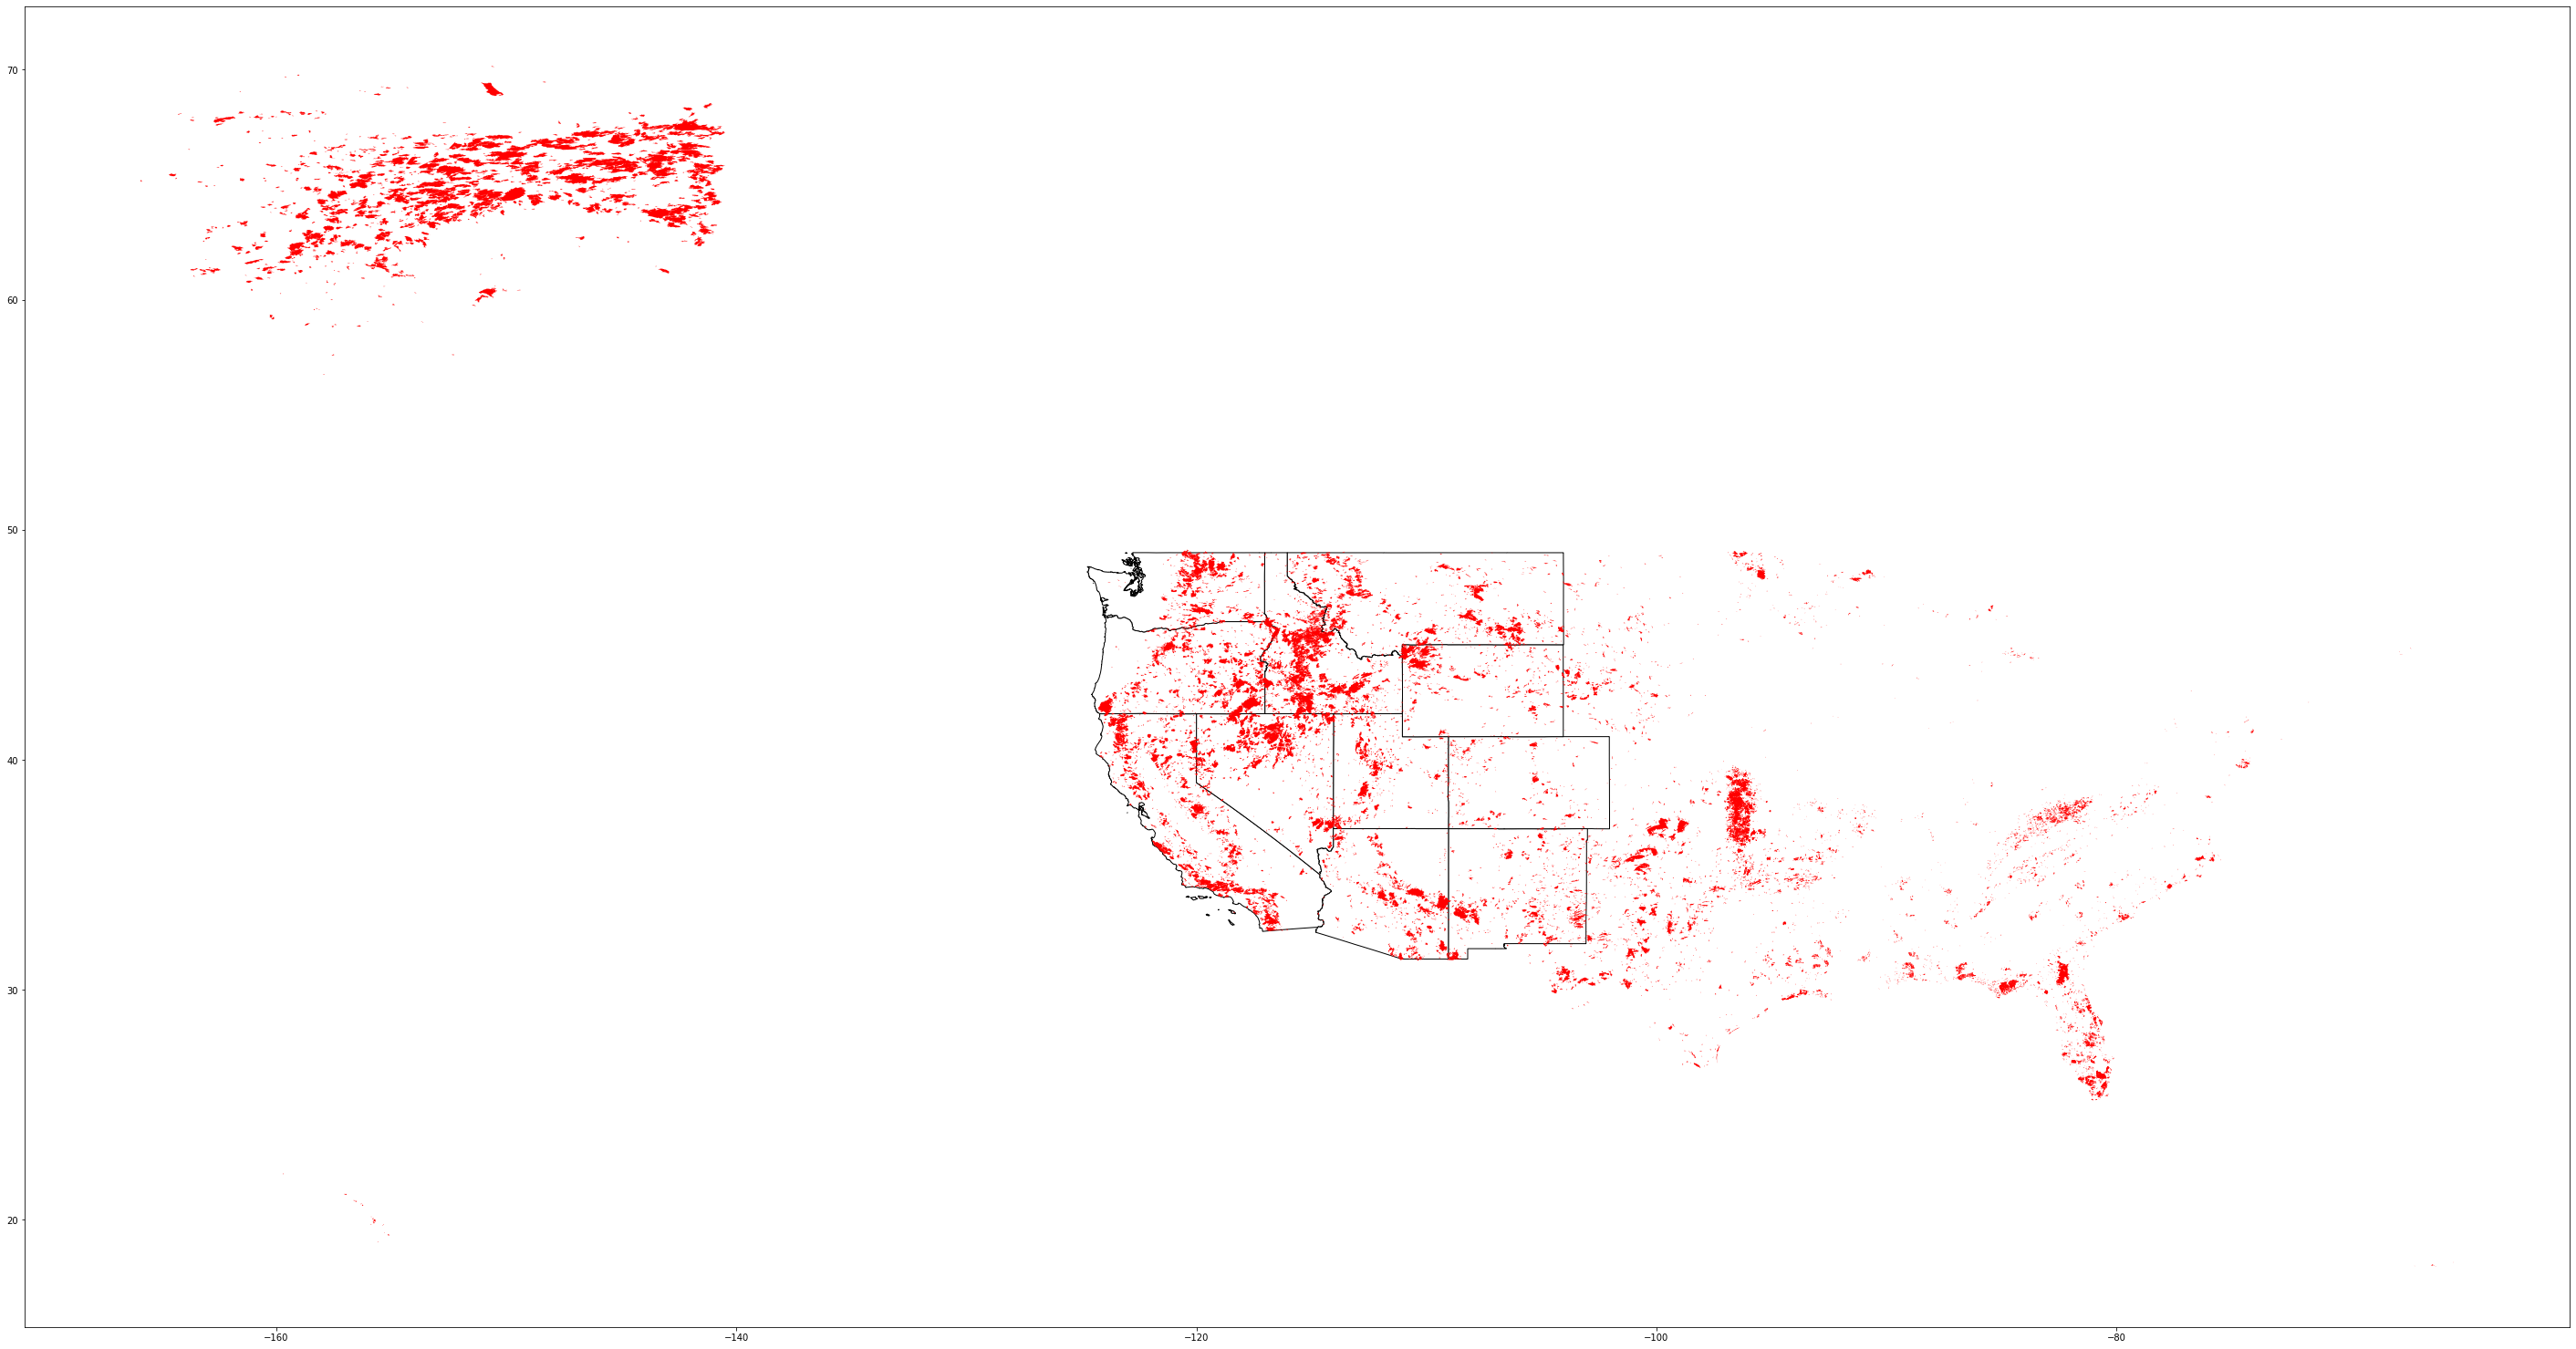

In [7]:
basemap = WestStates.plot(color = 'white', edgecolor = 'black')
MTBS.plot(ax=basemap, color = 'red')

In [8]:
mapcols = WestStates.columns.tolist()
mapcols_to_drop = [col for col in mapcols if col !='geometry']

In [9]:
## Dissolve borders within Western US

WestStates.loc[WestStates['STUSPS'].isin(West), 'Is_west'] = 1
dissolved_west = WestStates.dissolve(by='Is_west')
dissolved_west = dissolved_west.drop(mapcols_to_drop, axis=1).copy()

/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# Select only fire perimeters entirely within western US
West_MTBS = geopandas.sjoin(MTBS, dissolved_west, op='within')
West_MTBS = West_MTBS.drop(['index_right'], axis = 1)

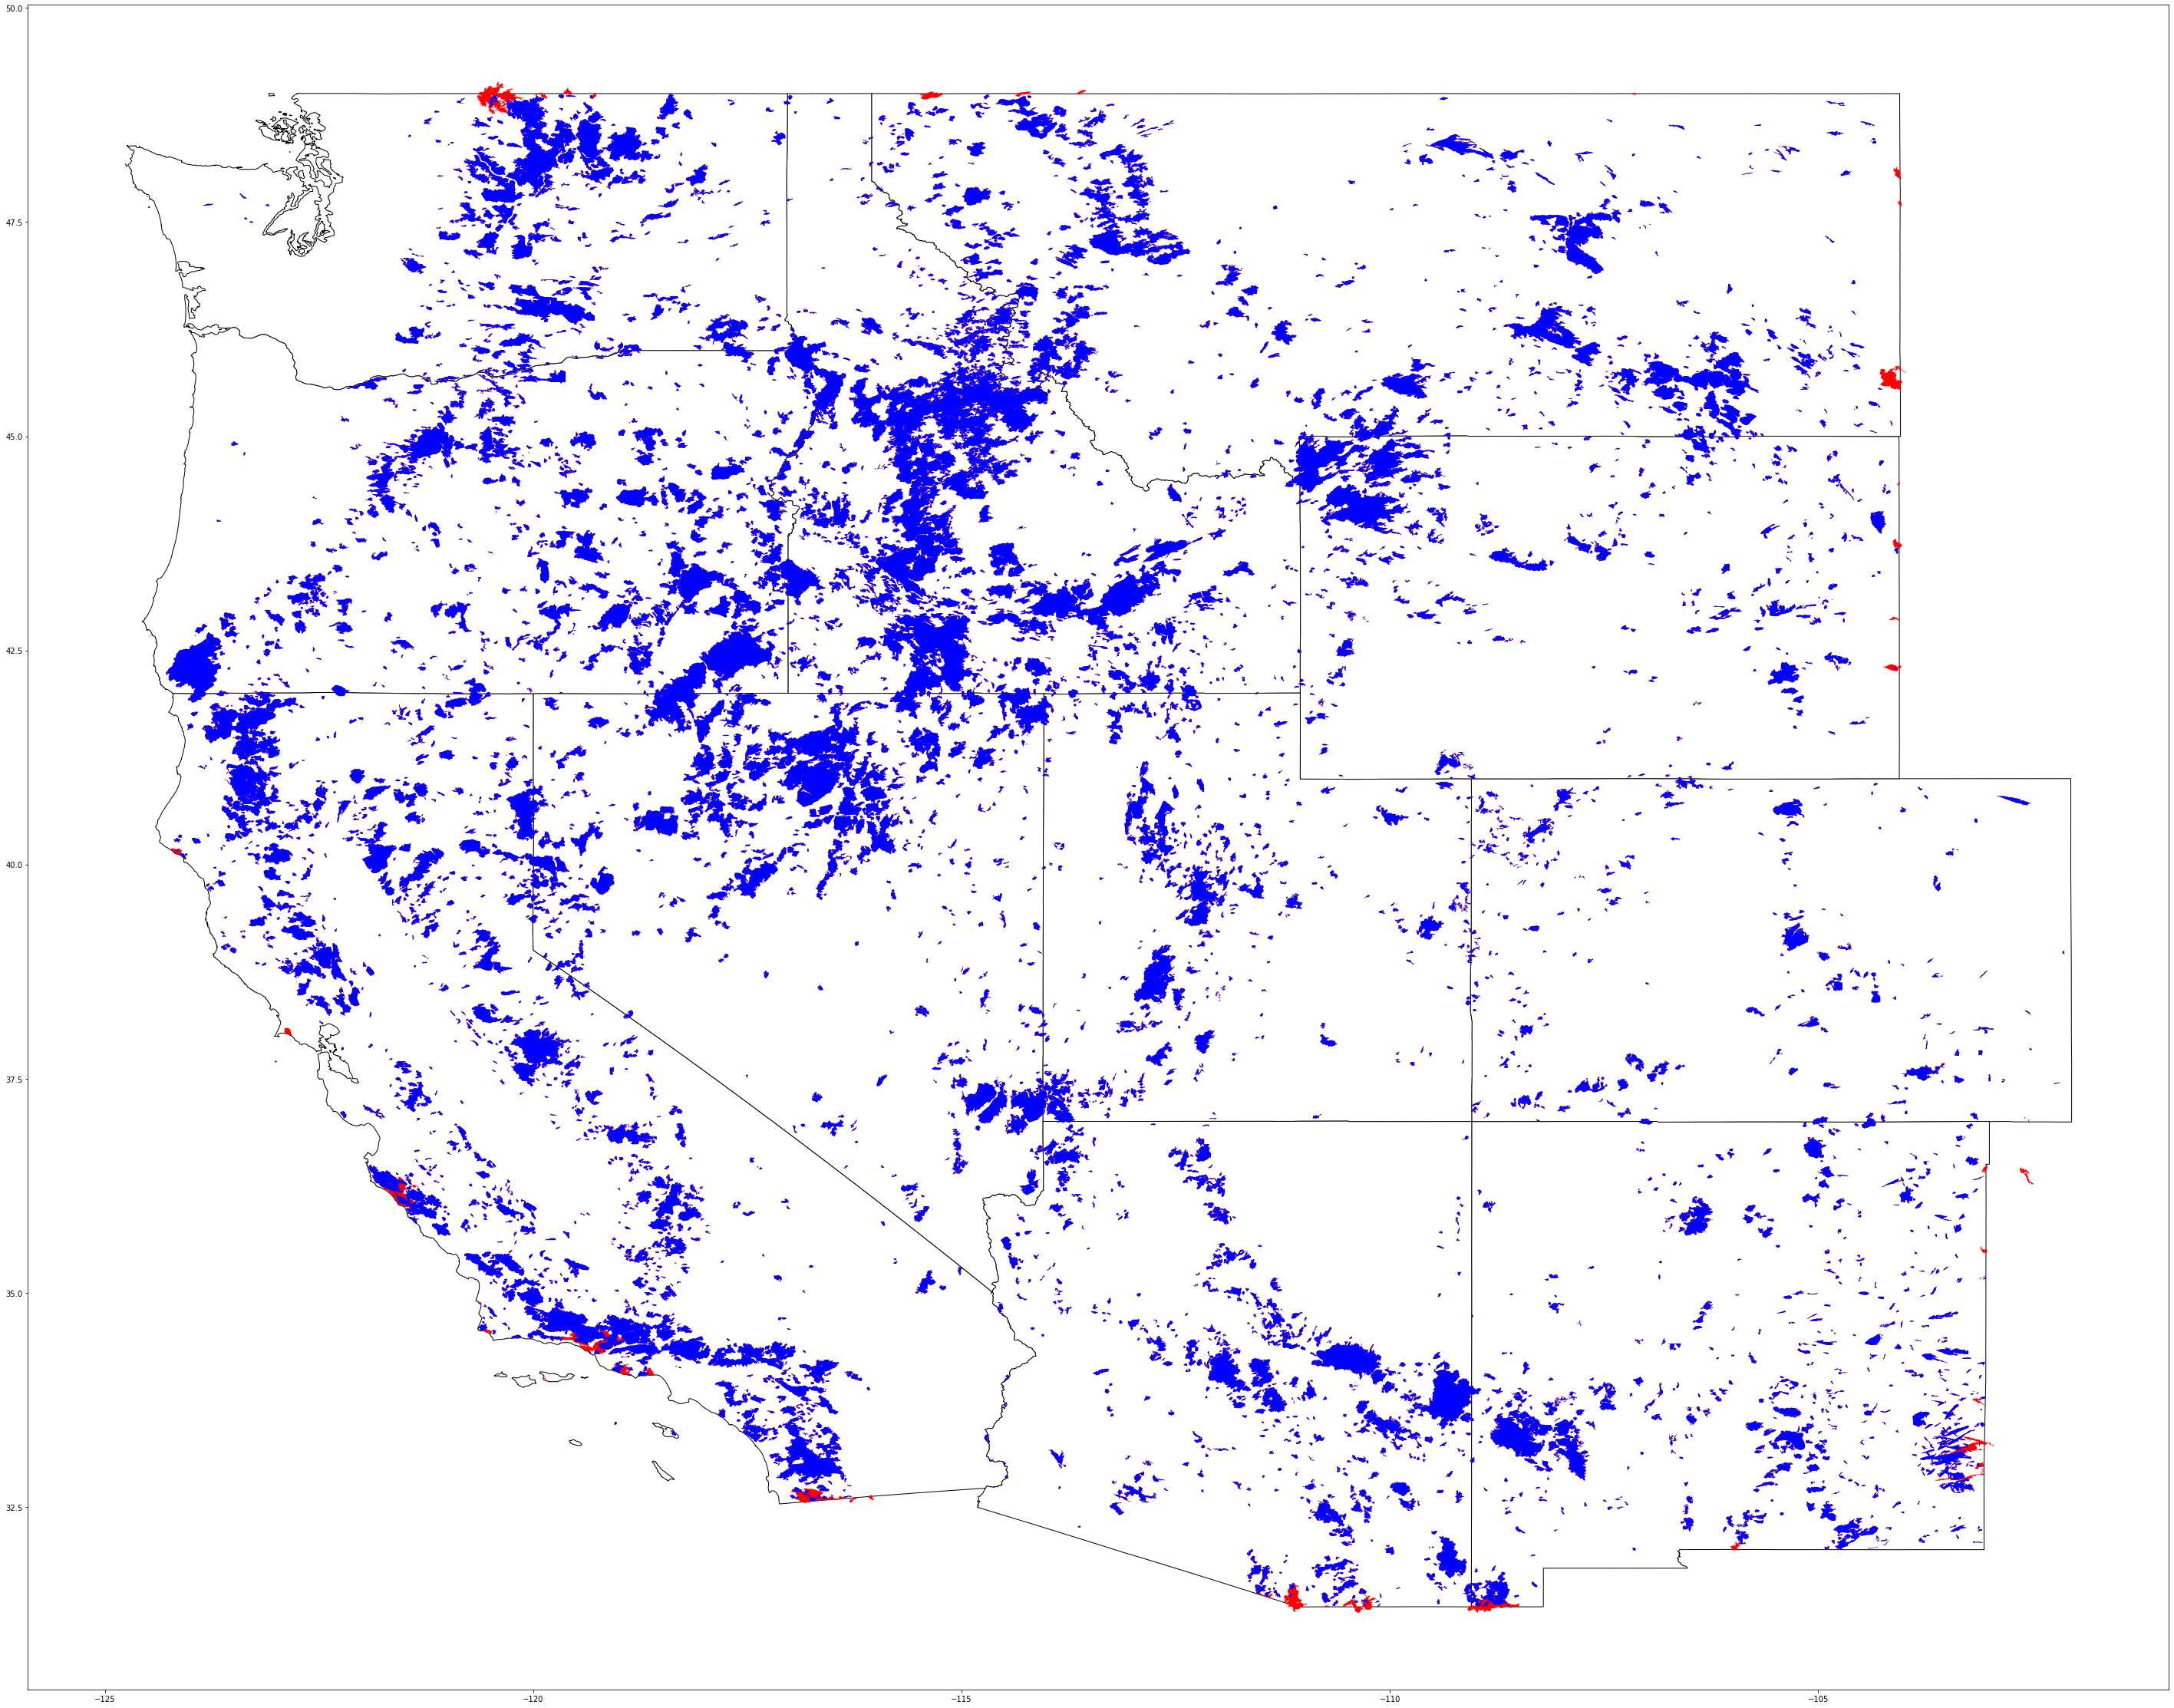

In [11]:
## Plot to check border fires (only want fires completly within states)

# Create West sample based on MTBS location naming
West_MTBS_sat = MTBS.loc[MTBS['Fire_ID'].str[0:2].isin(West)]

# Fires in red are not included in study since they are not completely contained in the Western US
basemap = WestStates.plot(edgecolor='black', color='white')
West_MTBS_sat.plot(ax=basemap,color='red')
West_MTBS.plot(ax=basemap,color='blue')

In [12]:
West_MTBS
# WestMTBS.sort_values(by=['Acres'], ascending=False)

Fire_ID       Fire_Name  Year  StartMonth  StartDay  \
1841   AZ3135011013020030413          BORDER  2003           4        13   
1843   AZ3135511029820060527             103  2006           5        27   
1844   AZ3135511067320110510       NORTHTANK  2011           5        10   
1847   AZ3136511064720070514     SAN ANTONIO  2007           5        14   
1849   AZ3137911075620110320            DUKE  2011           3        20   
...                      ...             ...   ...         ...       ...   
22962  WY4409110770020170623     HIDDEN DOME  2017           6        23   
22963  WY4443910972320170718            JUNE  2017           7        18   
22964  WY4468210625220170831  COTTONWOOD ONE  2017           8        31   
22965  WY4495610647120170831      DEER CREEK  2017           8        31   
22966  WY4498310578720170724       STALLIONS  2017           7        24   

      Fire_Type         Acres  \
1841   Wildfire   1367.000000   
1843   Wildfire   1696.000000   
1844   Wildfire   1179.000000   
1847   Wildfire   1743.000000   
1849   Wildfire   7656.000000   
...         ...           ...   
22962  Wildfire   2852.204617   
22963  Wildfire   1418.873535   
22964  Wildfire   4086.177893   
22965  Wildfire  90147.414181   
22966  Wildfire   1092.245767   

                                                geometry  
1841   POLYGON ((-110.12453 31.36359, -110.12379 31.3...  
1843   POLYGON ((-110.27974 31.36585, -110.27955 31.3...  
1844   POLYGON ((-110.65415 31.34819, -110.65406 31.3...  
1847   POLYGON ((-110.65851 31.36353, -110.65849 31.3...  
1849   POLYGON ((-110.75638 31.37158, -110.75820 31.3...  
...                                                  ...  
22962  POLYGON ((-107.65337 44.10316, -107.65118 44.1...  
22963  POLYGON ((-109.69709 44.42745, -109.69712 44.4...  
22964  POLYGON ((-106.23932 44.71145, -106.23852 44.7...  
22965  POLYGON ((-106.49118 45.09516, -106.48936 45.0...  
22966  POLYGON ((-105.79894 44.96897, -105.79979 44.9...  

[9073 rows x 8 columns]

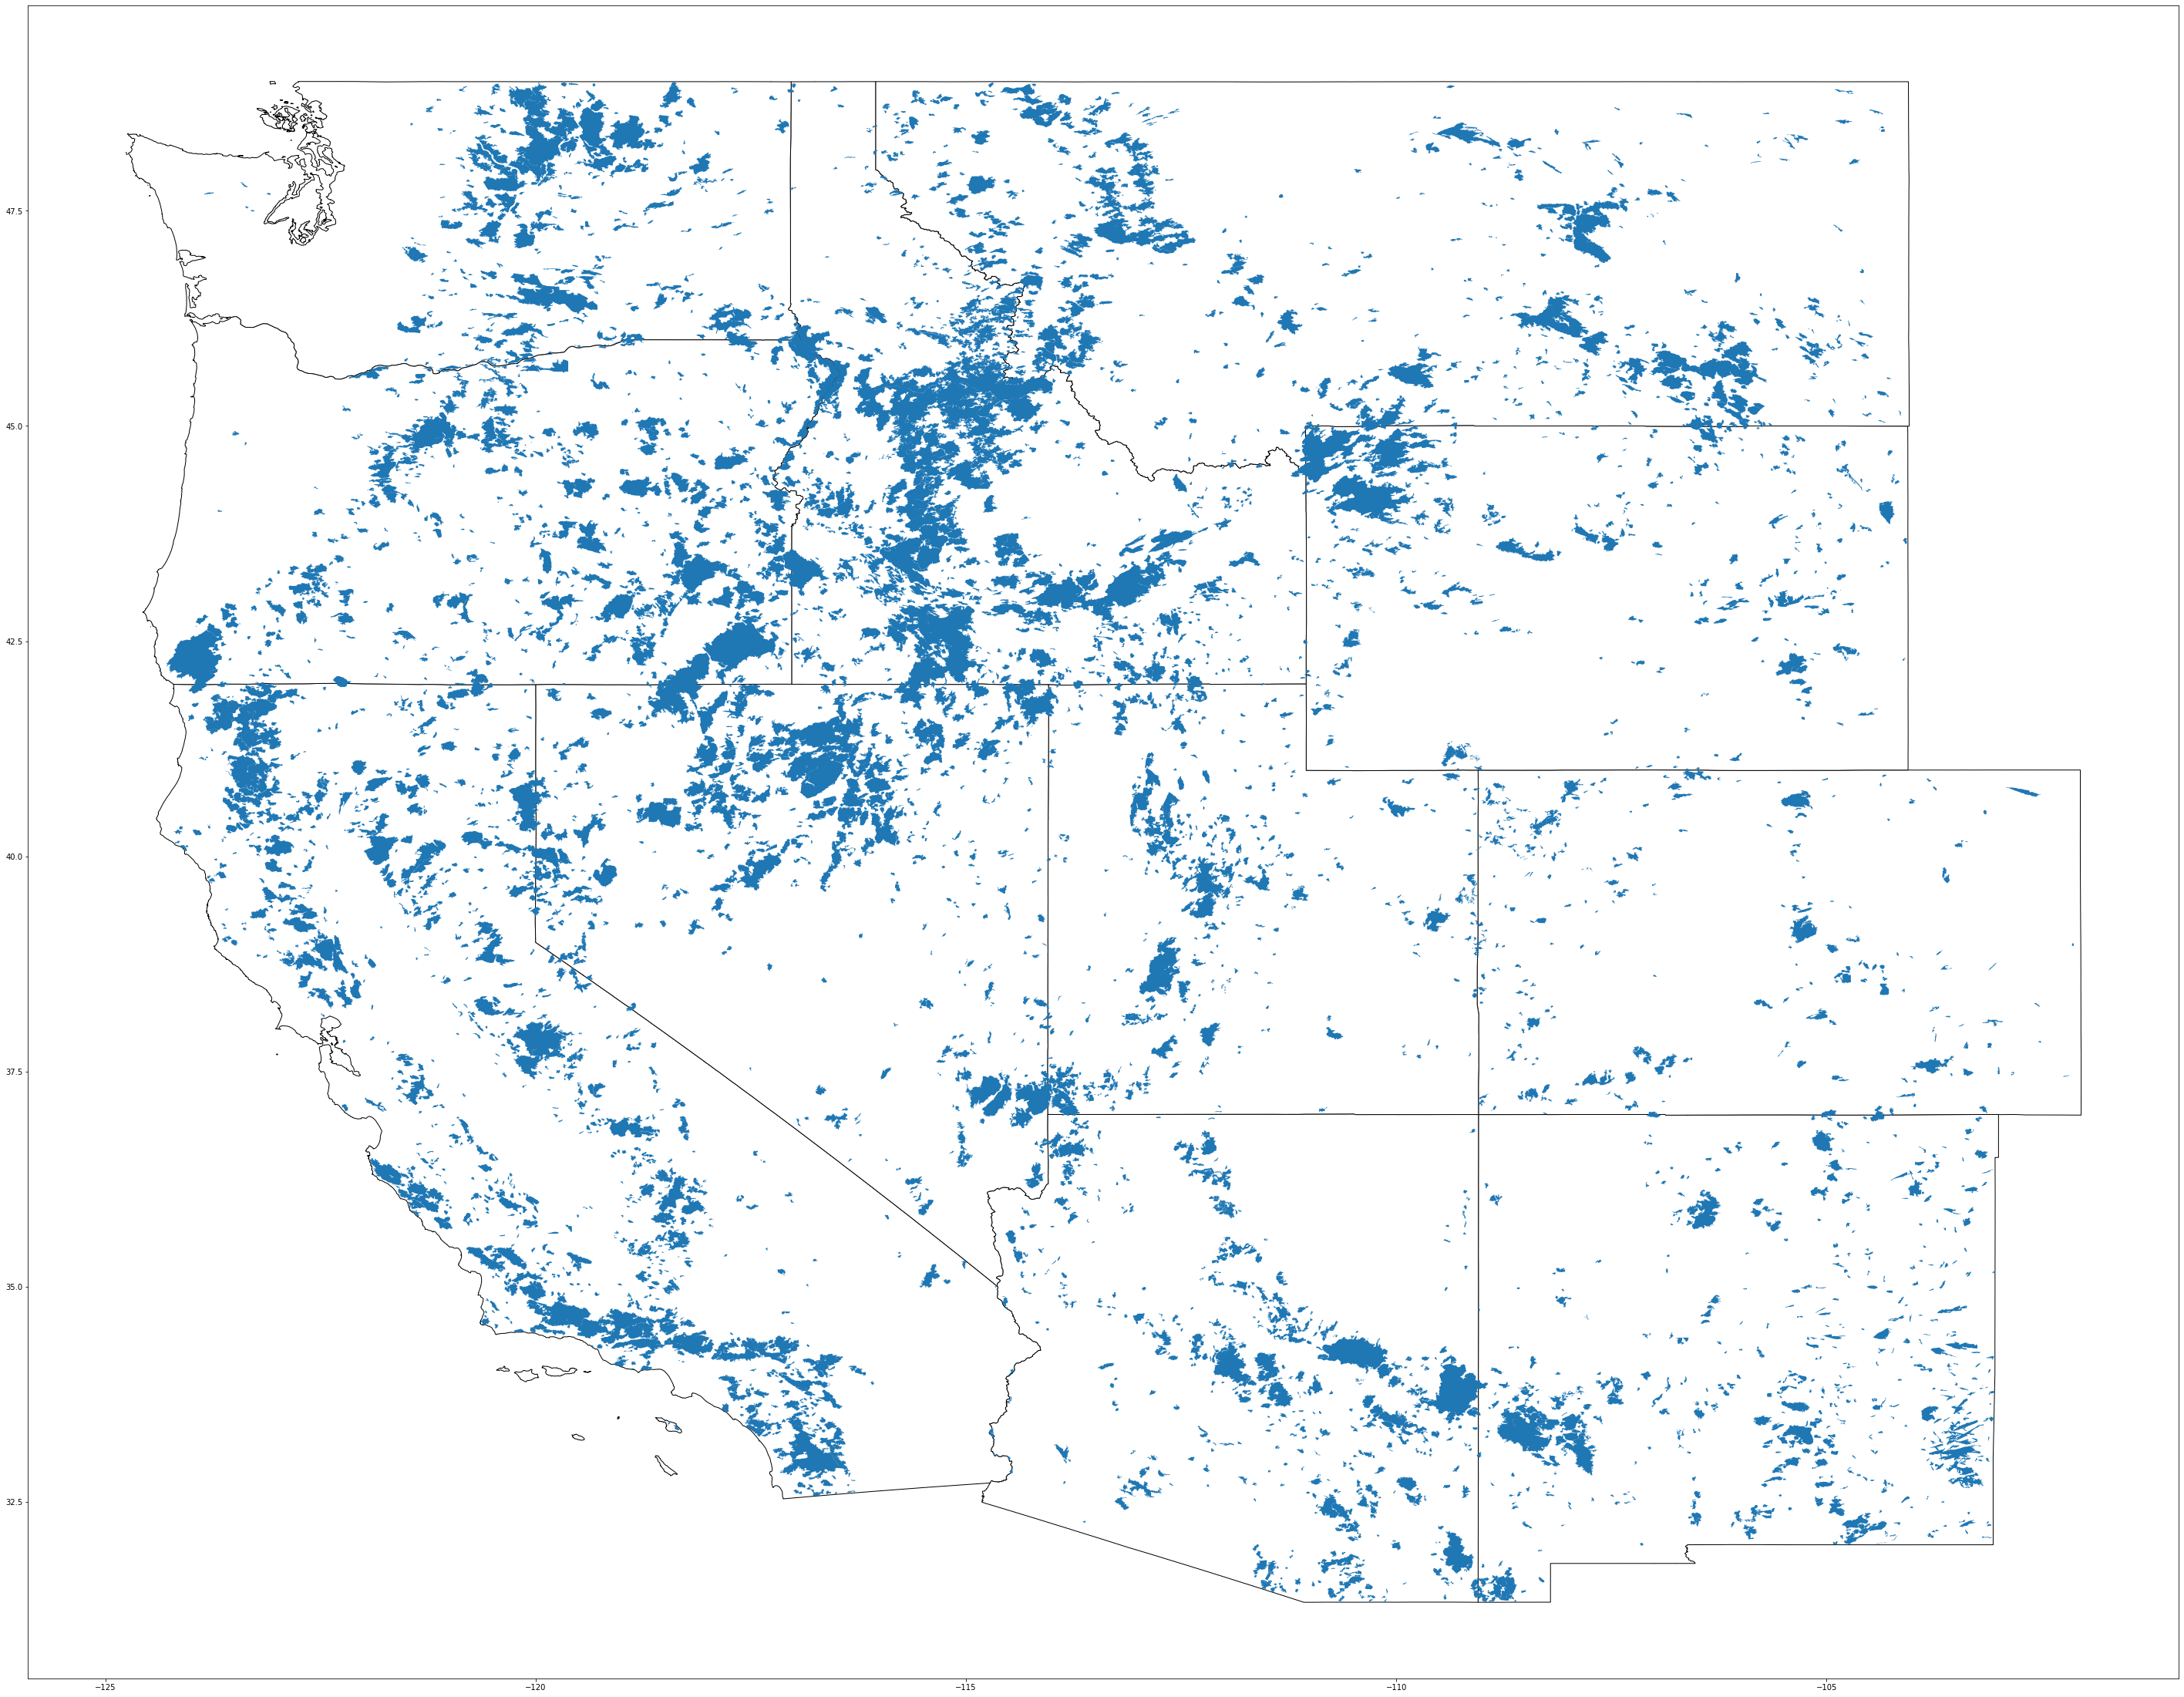

In [13]:
basemap = WestStates.plot(edgecolor='black',color='white')
West_MTBS.plot(ax=basemap)

In [14]:
# Read in 209 Data
ICS_209_inci = pd.read_csv(path + '/ics209-plus-wildfire/ics209-plus-wf_incidents_1999to2014.csv')
# ICS_209_inci.head(2)

# Create GeoDataFrame from ICS data
ICS = geopandas.GeoDataFrame(ICS_209_inci, geometry=geopandas.points_from_xy(ICS_209_inci.POO_LONGITUDE , ICS_209_inci.POO_LATITUDE))

/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,13,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
## Assign crs to ICS data
ICS.crs="epsg:4269"

In [16]:
ICS.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
# Select ICS forms for 11 Western United States (10319 fires)
WestICS = ICS[ICS['POO_STATE'].isin(West)].copy()

In [18]:
# Creat Dataset with MTBS and ICS
ICBS = pd.merge(West_MTBS, WestICS, left_on='Fire_ID', right_on='MTBS_ID', suffixes =('_from_MTBS','_from_ICS'))
ICBS.head(2)

Fire_ID Fire_Name  Year  StartMonth  StartDay Fire_Type  \
0  AZ3135011013020030413    BORDER  2003           4        13  Wildfire   
1  AZ3135511029820060527       103  2006           5        27  Wildfire   

    Acres                                 geometry_from_MTBS  Unnamed: 0  \
0  1367.0  POLYGON ((-110.12453 31.36359, -110.12379 31.3...        4172   
1  1696.0  POLYGON ((-110.27974 31.36585, -110.27955 31.3...        7833   

               INCIDENT_ID INCIDENT_NUMBER INCIDENT_NAME INCTYP_ABBREVIATION  \
0  2003_AZ-SAD-C570_BORDER     AZ-SAD-C570        BORDER                  WF   
1   2006_AZ-CNF-000048_103   AZ-CNF-000048           103                  WF   

   FINAL_ACRES CAUSE COMPLEX       DISCOVERY_DATE  DISCOVERY_DOY  \
0       1466.0     U   False  2003-04-13 11:00:00            103   
1       2050.0     H   False  2006-05-27 15:30:00            147   

  EXPECTED_CONTAINMENT_DATE  FATALITIES             FUEL_MODEL  \
0       2003-04-14 07:00:00         0.0                    NaN   
1       2006-06-05 18:00:00         0.0  Tall Grass (2.5 feet)   

  INCIDENT_DESCRIPTION  INC_IDENTIFIER  INJURIES_TOTAL LL_CONFIDENCE  \
0                  NaN             NaN             0.0           NaN   
1                  NaN             NaN             1.0           NaN   

  LL_UPDATE LOCAL_TIMEZONE POO_CITY POO_COUNTY  POO_LATITUDE  POO_LONGITUDE  \
0       NaN            NaN      NaN    Cochise     31.335000    -110.146944   
1       NaN            NaN      NaN    Cochise     31.351111    -110.313333   

             POO_SHORT_LOCATION_DESC POO_STATE  PROJECTED_FINAL_IM_COST  \
0             South of Palominas  AZ        AZ                      NaN   
1  8 miles south of Sierra Vista  AZ        AZ                1489500.0   

   START_YEAR SUPPRESSION_METHOD  STR_DAMAGED_TOTAL  STR_DAMAGED_COMM_TOTAL  \
0      2003.0                NaN                0.0                     0.0   
1      2006.0                NaN                0.0                     0.0   

   STR_DAMAGED_RES_TOTAL  STR_DESTROYED_TOTAL  STR_DESTROYED_COMM_TOTAL  \
0                    0.0                  0.0                       0.0   
1                    0.0                  0.0                       0.0   

   STR_DESTROYED_RES_TOTAL    FINAL_REPORT_DATE  INC_MGMT_NUM_SITREPS  \
0                      0.0  2003-04-15 00:00:00                     3   
1                      0.0  2006-06-05 00:00:00                     5   

  EVACUATION_REPORTED  STR_THREATENED_MAX  STR_THREATENED_COMM_MAX  \
0               False                 NaN                      NaN   
1               False               145.0                      5.0   

   STR_THREATENED_RES_MAX  TOTAL_AERIAL_SUM  TOTAL_PERSONNEL_SUM  \
0                     NaN               NaN                 82.0   
1                   140.0              19.0               1795.0   

   WF_PEAK_AERIAL  WF_PEAK_AERIAL_DATE  WF_PEAK_AERIAL_DOY  WF_PEAK_PERSONNEL  \
0             NaN  2003-04-13 17:00:00                 103               47.0   
1             5.0  2006-05-28 21:00:00                 148              502.0   

  WF_PEAK_PERSONNEL_DATE  WF_PEAK_PERSONNEL_DOY    WF_CESSATION_DATE  \
0    2003-04-13 17:00:00                    103  2003-04-14 00:00:00   
1    2006-05-30 18:00:00                    150  2006-05-28 21:00:00   

   WF_CESSATION_DOY  WF_MAX_FSR   WF_MAX_GROWTH_DATE  WF_MAX_GROWTH_DOY  \
0             104.0       800.0  2003-04-13 17:00:00                103   
1             148.0      2000.0  2006-05-28 21:00:00                148   

   WF_GROWTH_DURATION  FOD_NUM_FIRES  FOD_DISCOVERY_DOY  FOD_CONTAIN_DOY  \
0                 1.0            1.0              103.0            103.0   
1                 1.0            1.0              147.0            150.0   

  FOD_CAUSE_CODE FOD_CAUSE_DESCR  FOD_FIRE_SIZE FOD_COMPLEX_NAME  \
0              9   Miscellaneous         1466.0              NaN   
1              4        Campfire         1634.0              NaN   

            

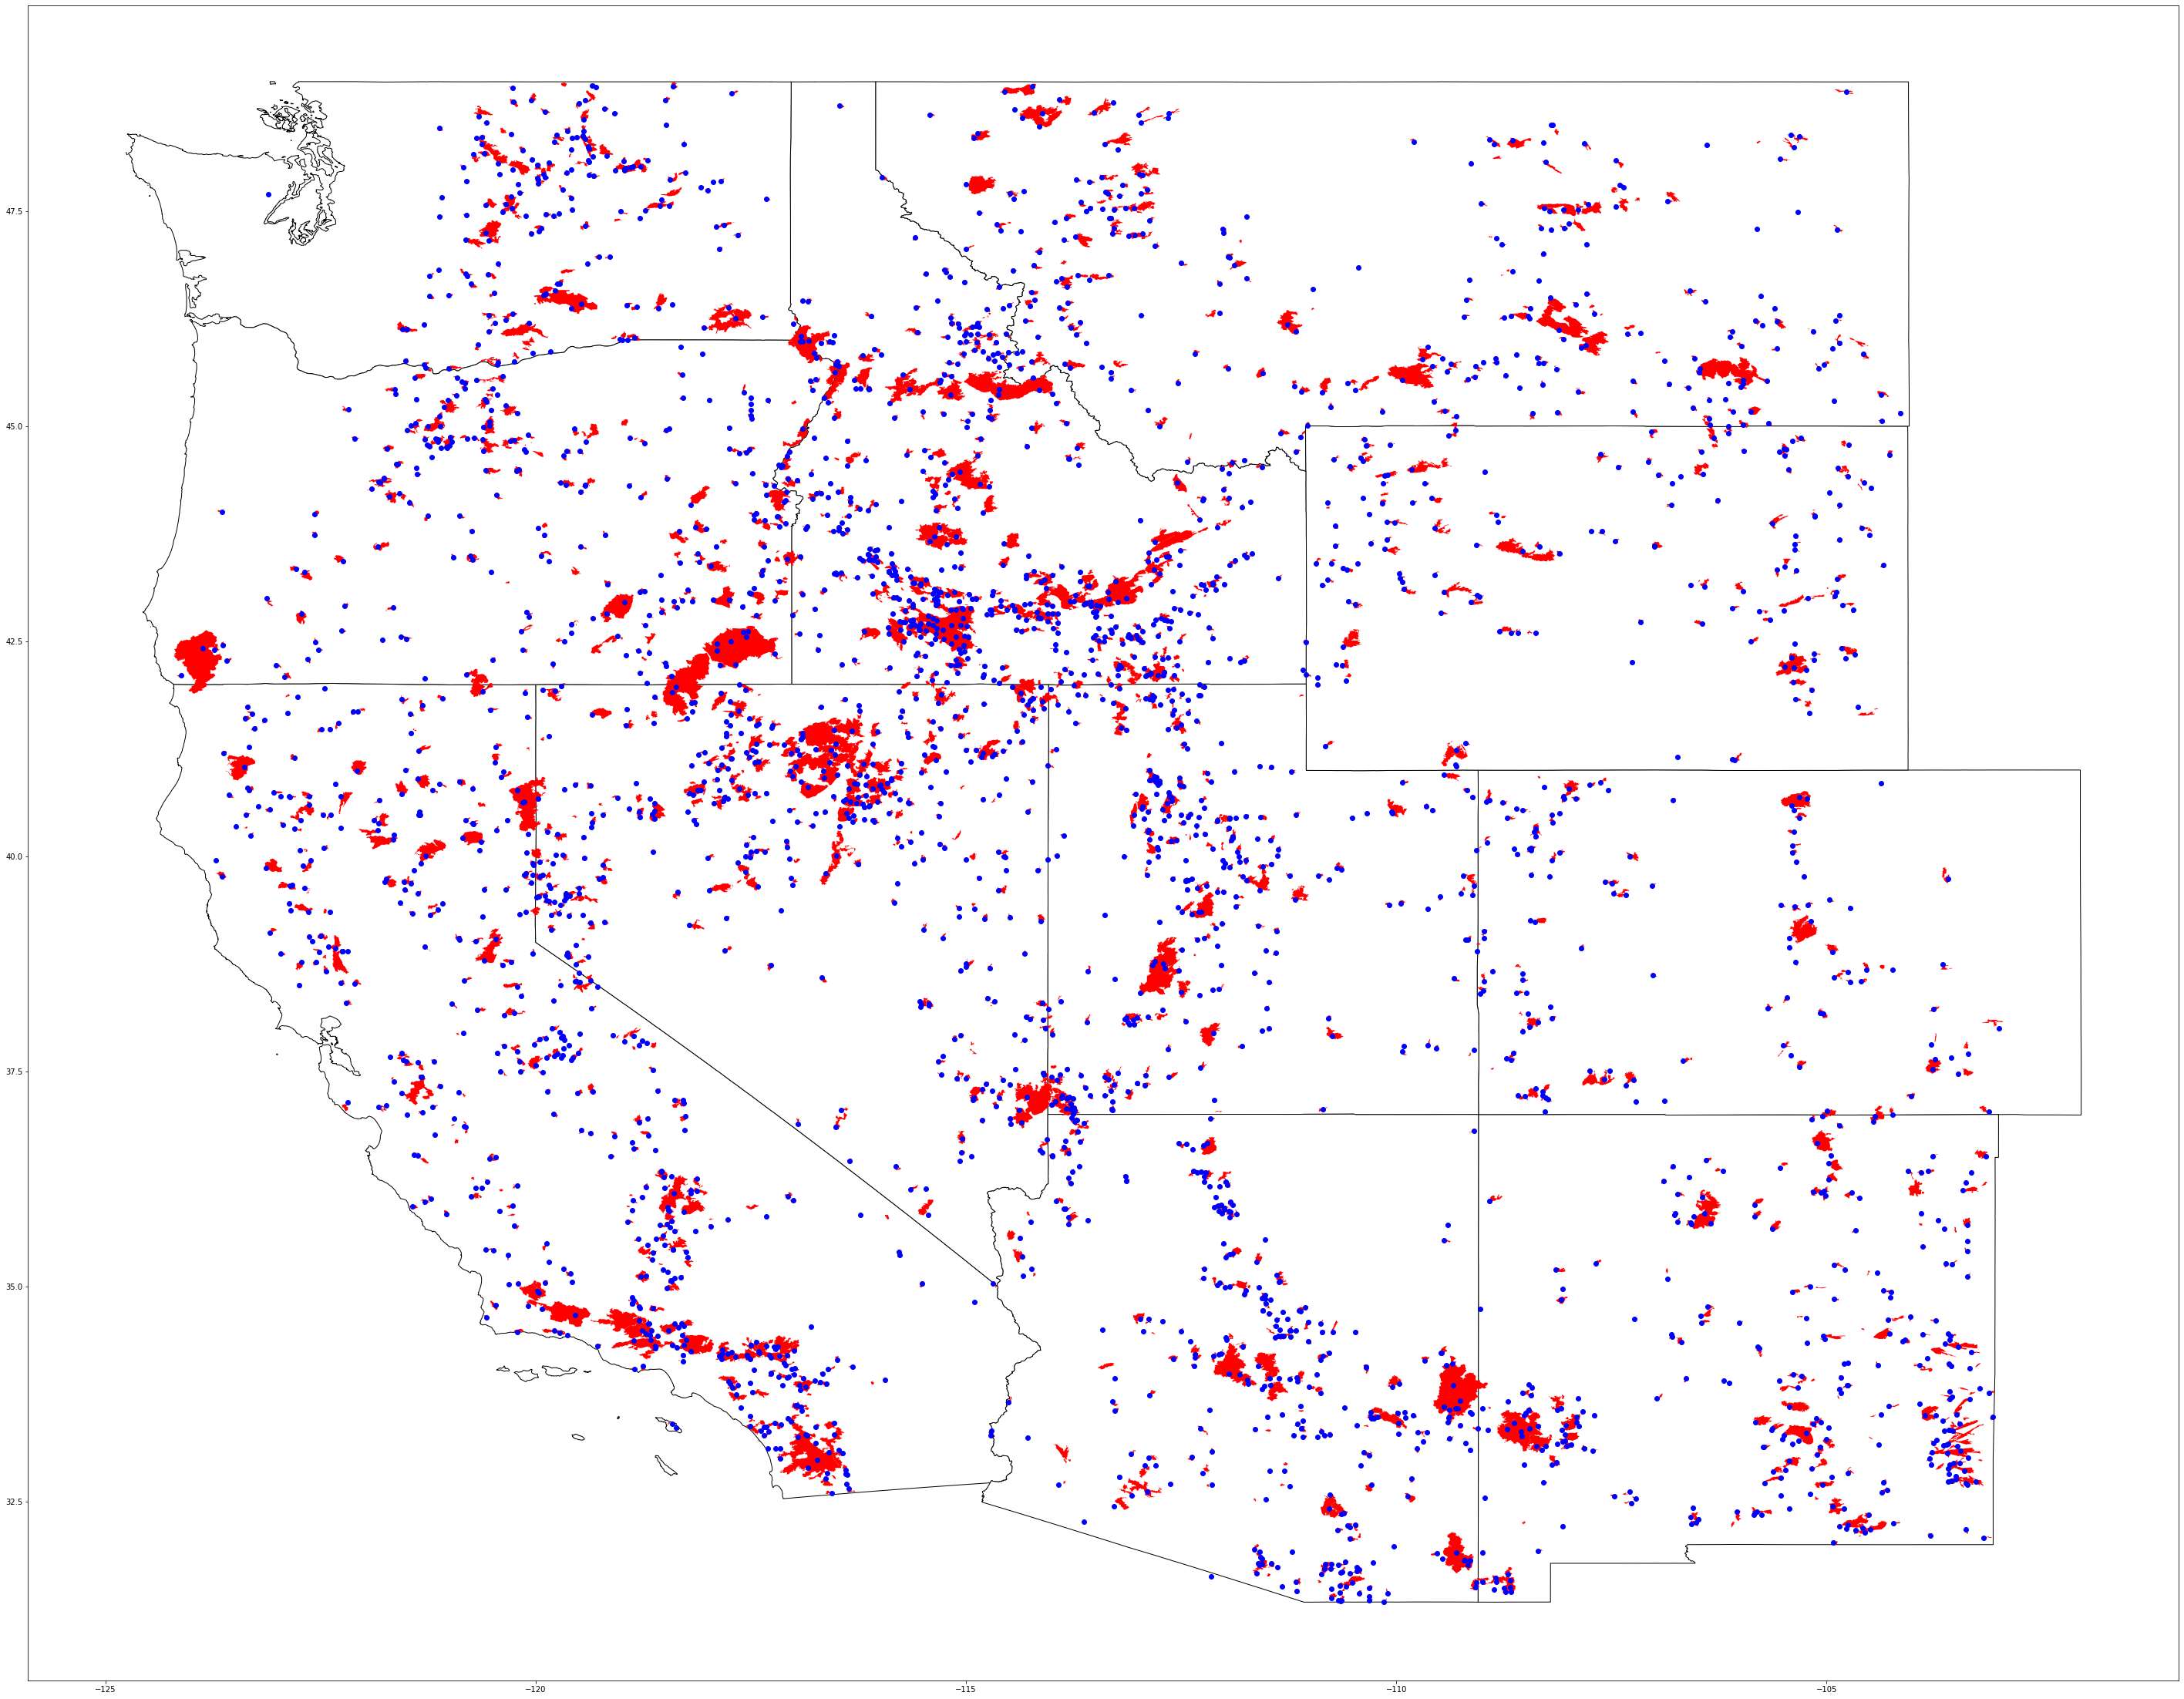

In [19]:
# Plot fire origins and perimeters

basemap = WestStates.plot(color = 'white', edgecolor = 'black')

# Fire perimeters
ICBS['geometry'] = ICBS['geometry_from_MTBS']
ICBS.plot(ax=basemap, color='red')

# Fire Point of Origins
ICBS['geometry'] = ICBS['geometry_from_ICS']
ICBS.plot(ax=basemap, color='blue')

In [20]:
ICBS.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [21]:
# Project Fires into North American Equal area 2163
ICBS_proj = ICBS.copy()
WestStatesMap_proj = WestStates.to_crs("EPSG:2163")

# Project MTBS perimeters
ICBS_proj['geometry'] = ICBS_proj['geometry_from_MTBS'].copy()
ICBS_proj['geometry'] = ICBS_proj['geometry'].to_crs("EPSG:2163")
ICBS_proj['geometry_from_MTBS'] = ICBS_proj['geometry'].copy()

# Project ICS POO perimeter
ICBS_proj['geometry'] = ICBS_proj['geometry_from_ICS'].copy()
ICBS_proj = ICBS_proj.to_crs("EPSG:2163")
ICBS_proj['geometry_from_ICS'] = ICBS_proj['geometry'].copy()

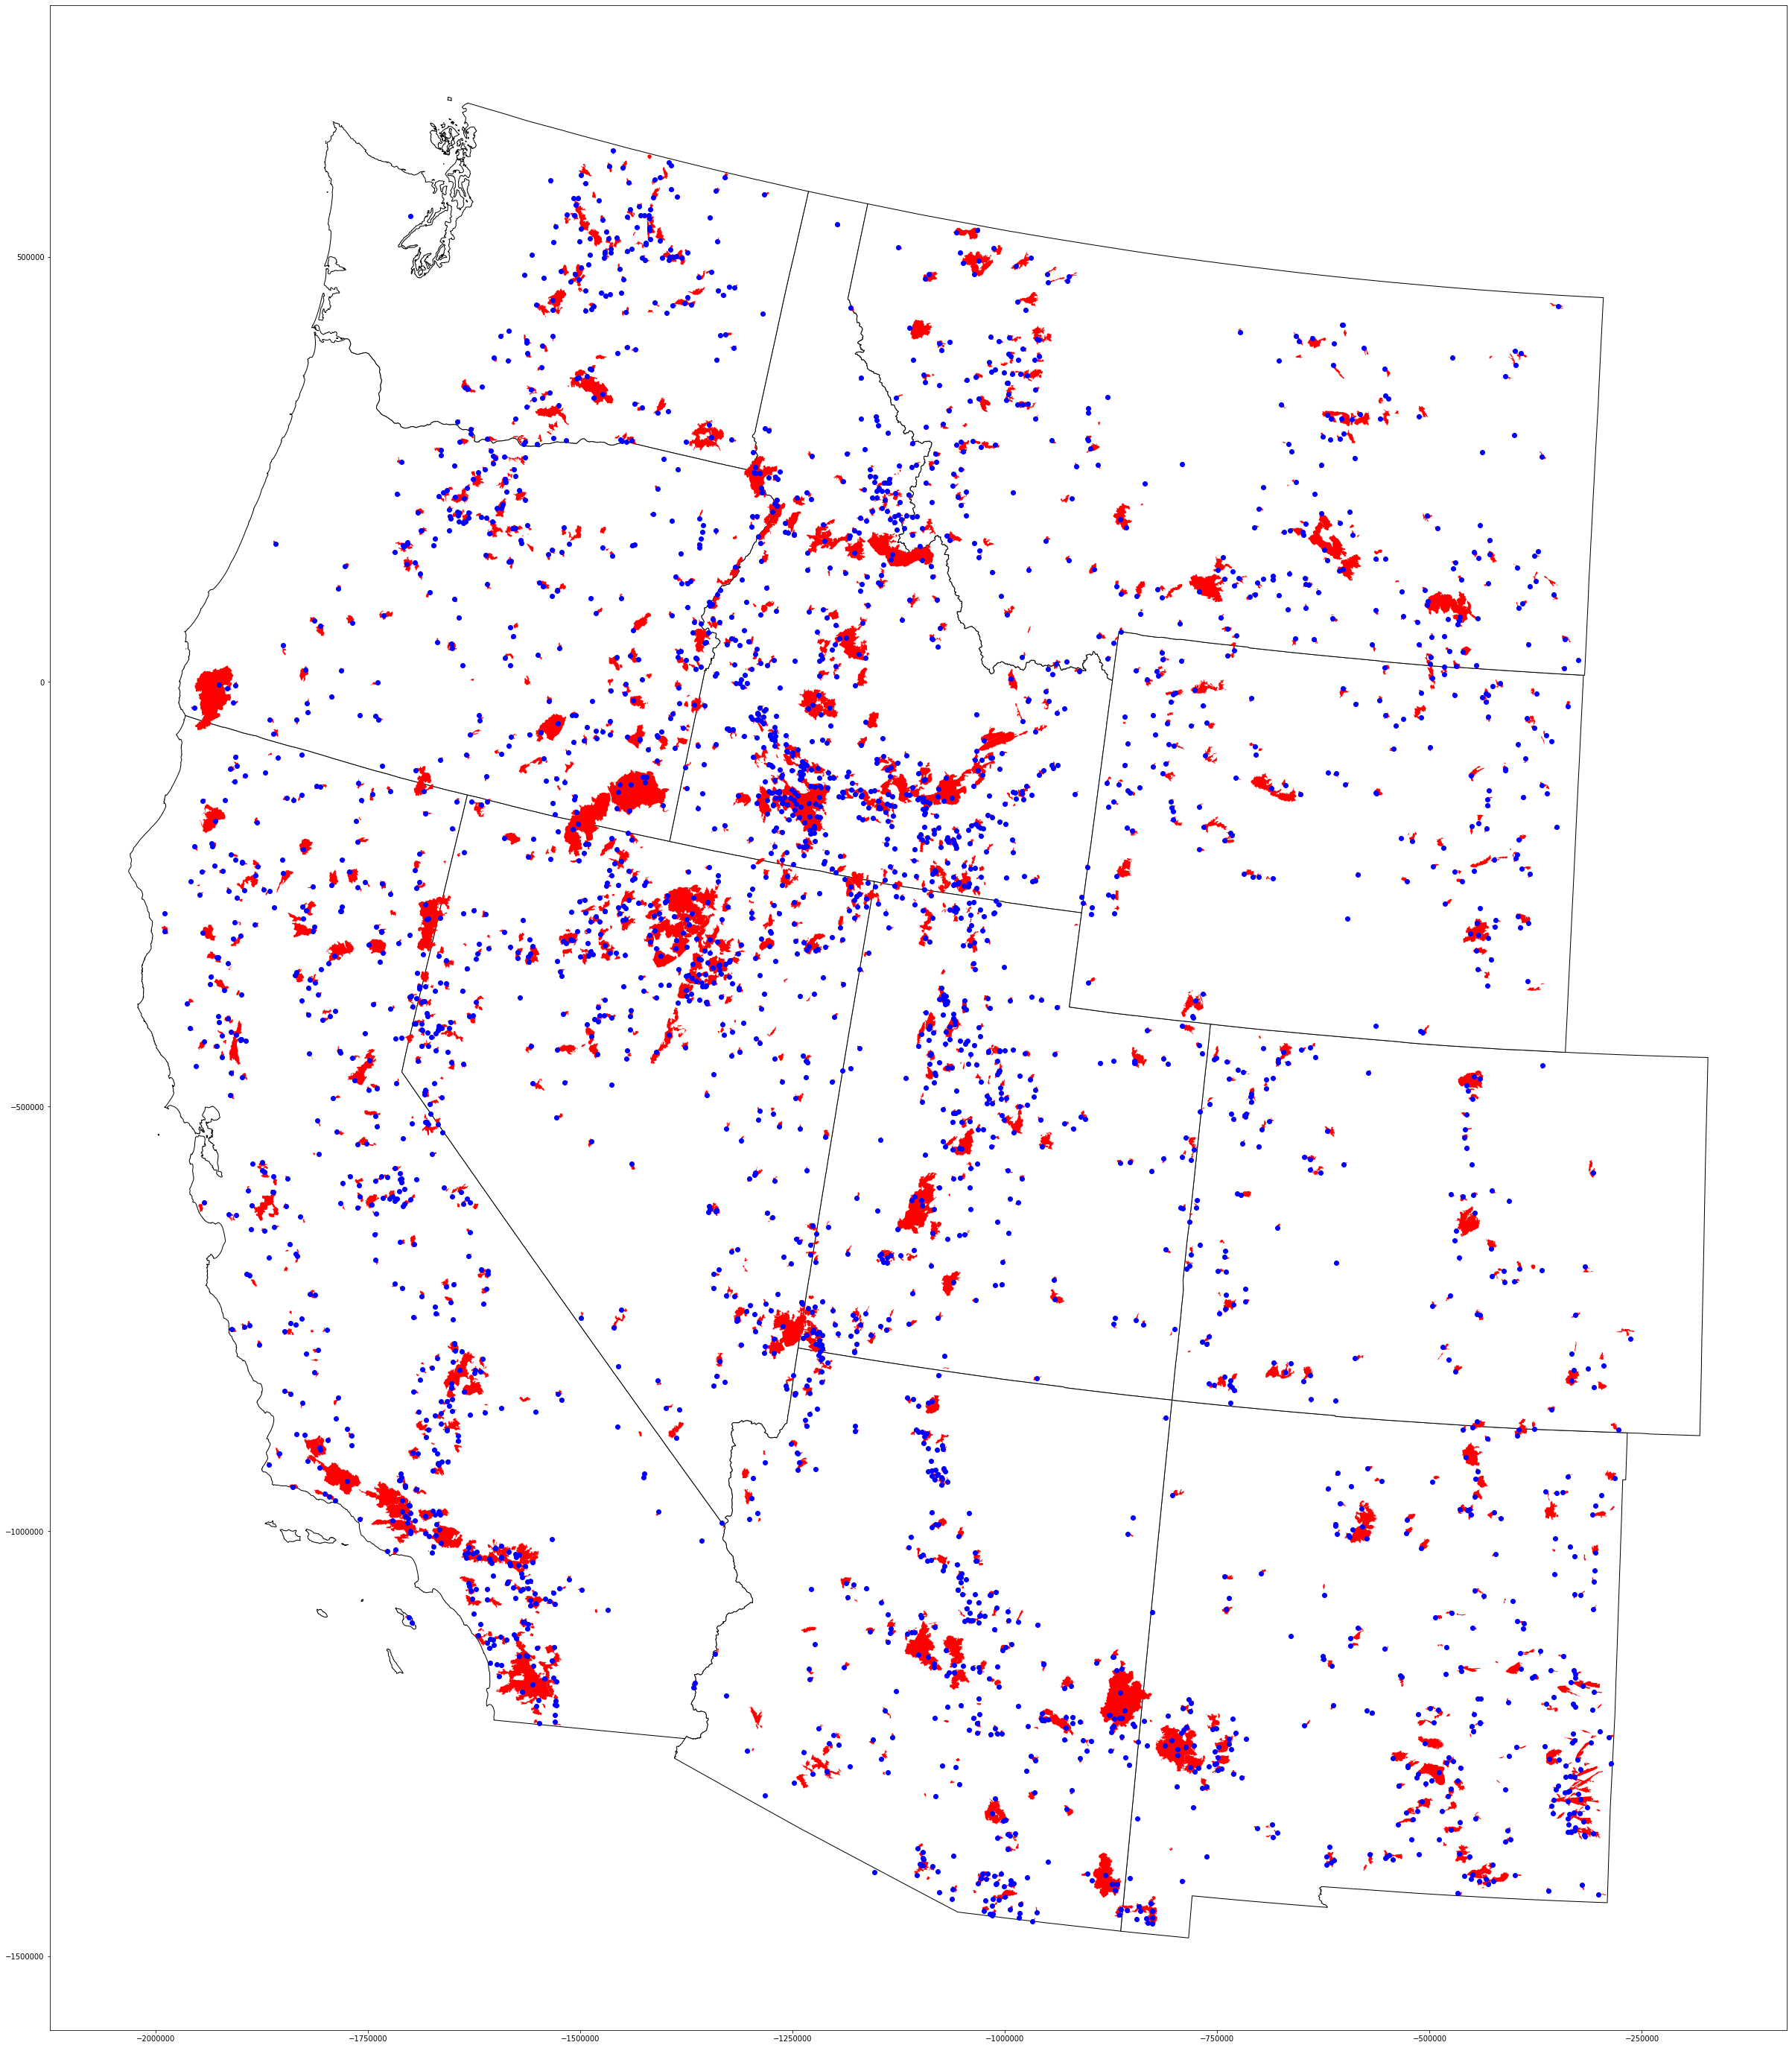

In [22]:
# Plot projected data
basemap = WestStatesMap_proj.plot(edgecolor = 'black', color='white')

ICBS_proj['geometry'] = ICBS_proj['geometry_from_MTBS']
ICBS_proj.plot(ax=basemap, color = 'red')

ICBS_proj['geometry'] = ICBS_proj['geometry_from_ICS']
ICBS_proj.plot(ax=basemap, color = 'blue')

In [23]:
# ICBS_proj.sort_values(by=['Acres'], ascending=False)

In [24]:
ICBS_proj.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [25]:
ICBS_proj['geometry'] = ICBS_proj['geometry_from_MTBS'].copy()
# Dist = ICBS_proj[['Fire_ID']].copy()

def get_distance(row):
    distance = row.geometry.distance(row.geometry_from_ICS)
    return distance

ICBS_proj['POO_to_perim'] = ICBS_proj.apply(lambda row: get_distance(row), axis=1)

In [26]:
## Look at point of origin to perimeter distances

# ICBS_proj['POO_to_perim'].describe()
# ICBS_proj.sort_values(by=['POO_to_perim'], ascending=False)

In [27]:
## Check for point of origins which are way off in the reporting

#WayOff = ICBS_proj.loc[(ICBS_proj['POO_to_perim'] >= 100)].copy() #& (ICBS_proj['POO_to_perim'] <= 39280)]
# WayOff.sort_values(by=['Acres'], ascending=False)
# basemap = WestStatesMap_proj.plot(edgecolor = 'black', color='white')
# WayOff.plot(ax = basemap)
# WayOff['geometry'] = WayOff['geometry_from_ICS'].copy()
# WayOff.plot(ax=basemap, color='red')

In [28]:
# Select only fires with point of origin within 100 meters of final perimeter
Fires = ICBS_proj.loc[(ICBS_proj['POO_to_perim'] <= 100)].copy() 
Fires.POO_to_perim.describe()

count    1797.000000
mean        5.737802
std        17.902362
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        99.754805
Name: POO_to_perim, dtype: float64

In [29]:
Fires_intersect = geopandas.sjoin(Fires, WestStatesMap_proj, op='intersects')
Fires_within = geopandas.sjoin(Fires, WestStatesMap_proj, op='within')

In [30]:
ID_fires_intersect = Fires_intersect.loc[Fires_intersect['STUSPS']=='ID'].copy()
ID_fires_within = Fires_within.loc[Fires_within['STUSPS']=='ID'].copy()

In [38]:
ID_fires_within

Fire_ID       Fire_Name  Year  StartMonth  StartDay  \
894   ID4206211454420100820      MULE CREEK  2010           8        20   
898   ID4209911480020010704       NORTH CAN  2001           7         4   
899   ID4210111480120100806  CHINA MOUNTAIN  2010           8         6   
902   ID4211211345420070707        JIM SAGE  2007           7         7   
907   ID4213811276820060805         STONE 2  2006           8         5   
...                     ...             ...   ...         ...       ...   
1369  ID4681611523420000804       ELIZABETH  2000           8         4   
1372  ID4871711645620030902    MYRTLE CREEK  2003           9         2   
1448  MT4576211467220120808     BEAVER JACK  2012           8         8   
1456  MT4582711468420120808  GREEN MOUNTAIN  2012           8         8   
1461  MT4584711463020120808     BURNT STRIP  2012           8         8   

     Fire_Type    Acres                                 geometry_from_MTBS  \
894   Wildfire  14062.0  POLYGON ((-1199639.906 -224469.356, -1199640.9...   
898   Wildfire   3446.0  POLYGON ((-1216041.165 -213572.518, -1215966.6...   
899   Wildfire   1730.0  POLYGON ((-1215170.654 -212583.678, -1215149.6...   
902   Wildfire   5243.0  POLYGON ((-1106465.276 -229703.705, -1106457.0...   
907   Wildfire  50677.0  POLYGON ((-1050057.182 -229843.220, -1050079.0...   
...        ...      ...                                                ...   
1369  Wildfire   3203.0  POLYGON ((-1150224.115 308553.754, -1150348.25...   
1372  Wildfire   3539.0  POLYGON ((-1199411.210 539620.940, -1199408.38...   
1448  Wildfire   2954.0  POLYGON ((-1131502.368 189617.281, -1131502.50...   
1456  Wildfire   3616.0  POLYGON ((-1127723.163 196655.489, -1127692.34...   
1461  Wildfire   4401.0  POLYGON ((-1122078.080 195163.442, -1122100.81...   

      Unnamed: 0                        INCIDENT_ID INCIDENT_NUMBER  \
894        16829      2010_ID-TWX-000384_MULE CREEK   ID-TWX-000384   
898         2432         2001_ID-BOD-F174_NORTH CAN     ID-BOD-F174   
899        16818  2010_ID-TFD-000335_CHINA MOUNTAIN   ID-TFD-000335   
902        11242        2007_ID-TFD-001953_JIM SAGE   ID-TFD-001953   
907         8366           2006_ID-IFD-000030_BOWEN   ID-IFD-000030   
...          ...                                ...             ...   
1369        1164        2000_ID-CWF-18504_ELIZABETH    ID-CWF-18504   
1372        4571      2003_ID-IPF-7027_MYRTLE CREEK     ID-IPF-7027   
1448       21314     2012_MT-BRF-005535_BEAVER JACK   MT-BRF-005535   
1456       21312  2012_MT-BRF-005529_GREEN MOUNTAIN   MT-BRF-005529   
1461       21311     2012_MT-BRF-005526_BURNT STRIP   MT-BRF-005526   

       INCIDENT_NAME INCTYP_ABBREVIATION  FINAL_ACRES CAUSE COMPLEX  \
894       MULE CREEK                  WF      13745.0     H   False   
898        NORTH CAN                  WF       3133.0     L   False   
899   CHINA MOUNTAIN                  WF       1729.0     L   False   
902         JIM SAGE                  WF       5400.0     L   False   
907            BOWEN                  WF      19481.0     L   False   
...              ...                 ...          ...   ...     ...   
1369       ELIZABETH                  WF       3258.0     L   False   
1372    MYRTLE CREEK                  WF       3600.0     H   False   
1448     BEAVER JACK                  WF       2408.0     L   False   
1456  GREEN MOUNTAIN                  WF       2968.0     L   False   
1461     BURNT STRIP                  WF       3570.0     L   False   

           DISCOVERY_DATE  DISCOVERY_DOY EXPECTED_CONTAINMENT_DATE  \
894   2010-08-20 13:14:00            232       2010-08-21 00:00:00   
898   2001-07-04 00:00:00            185       2001-07-06 00:00:00   
899   2010-08-06 10:23:00            218       2010-08-09 00:00:00   
902   2007-07-07 03:15:00            188       2007-07-11 00:00:00   
907   2006-08-15 06:01:00            227       2006-08-17 20:00:00   
...                   ...            ...                

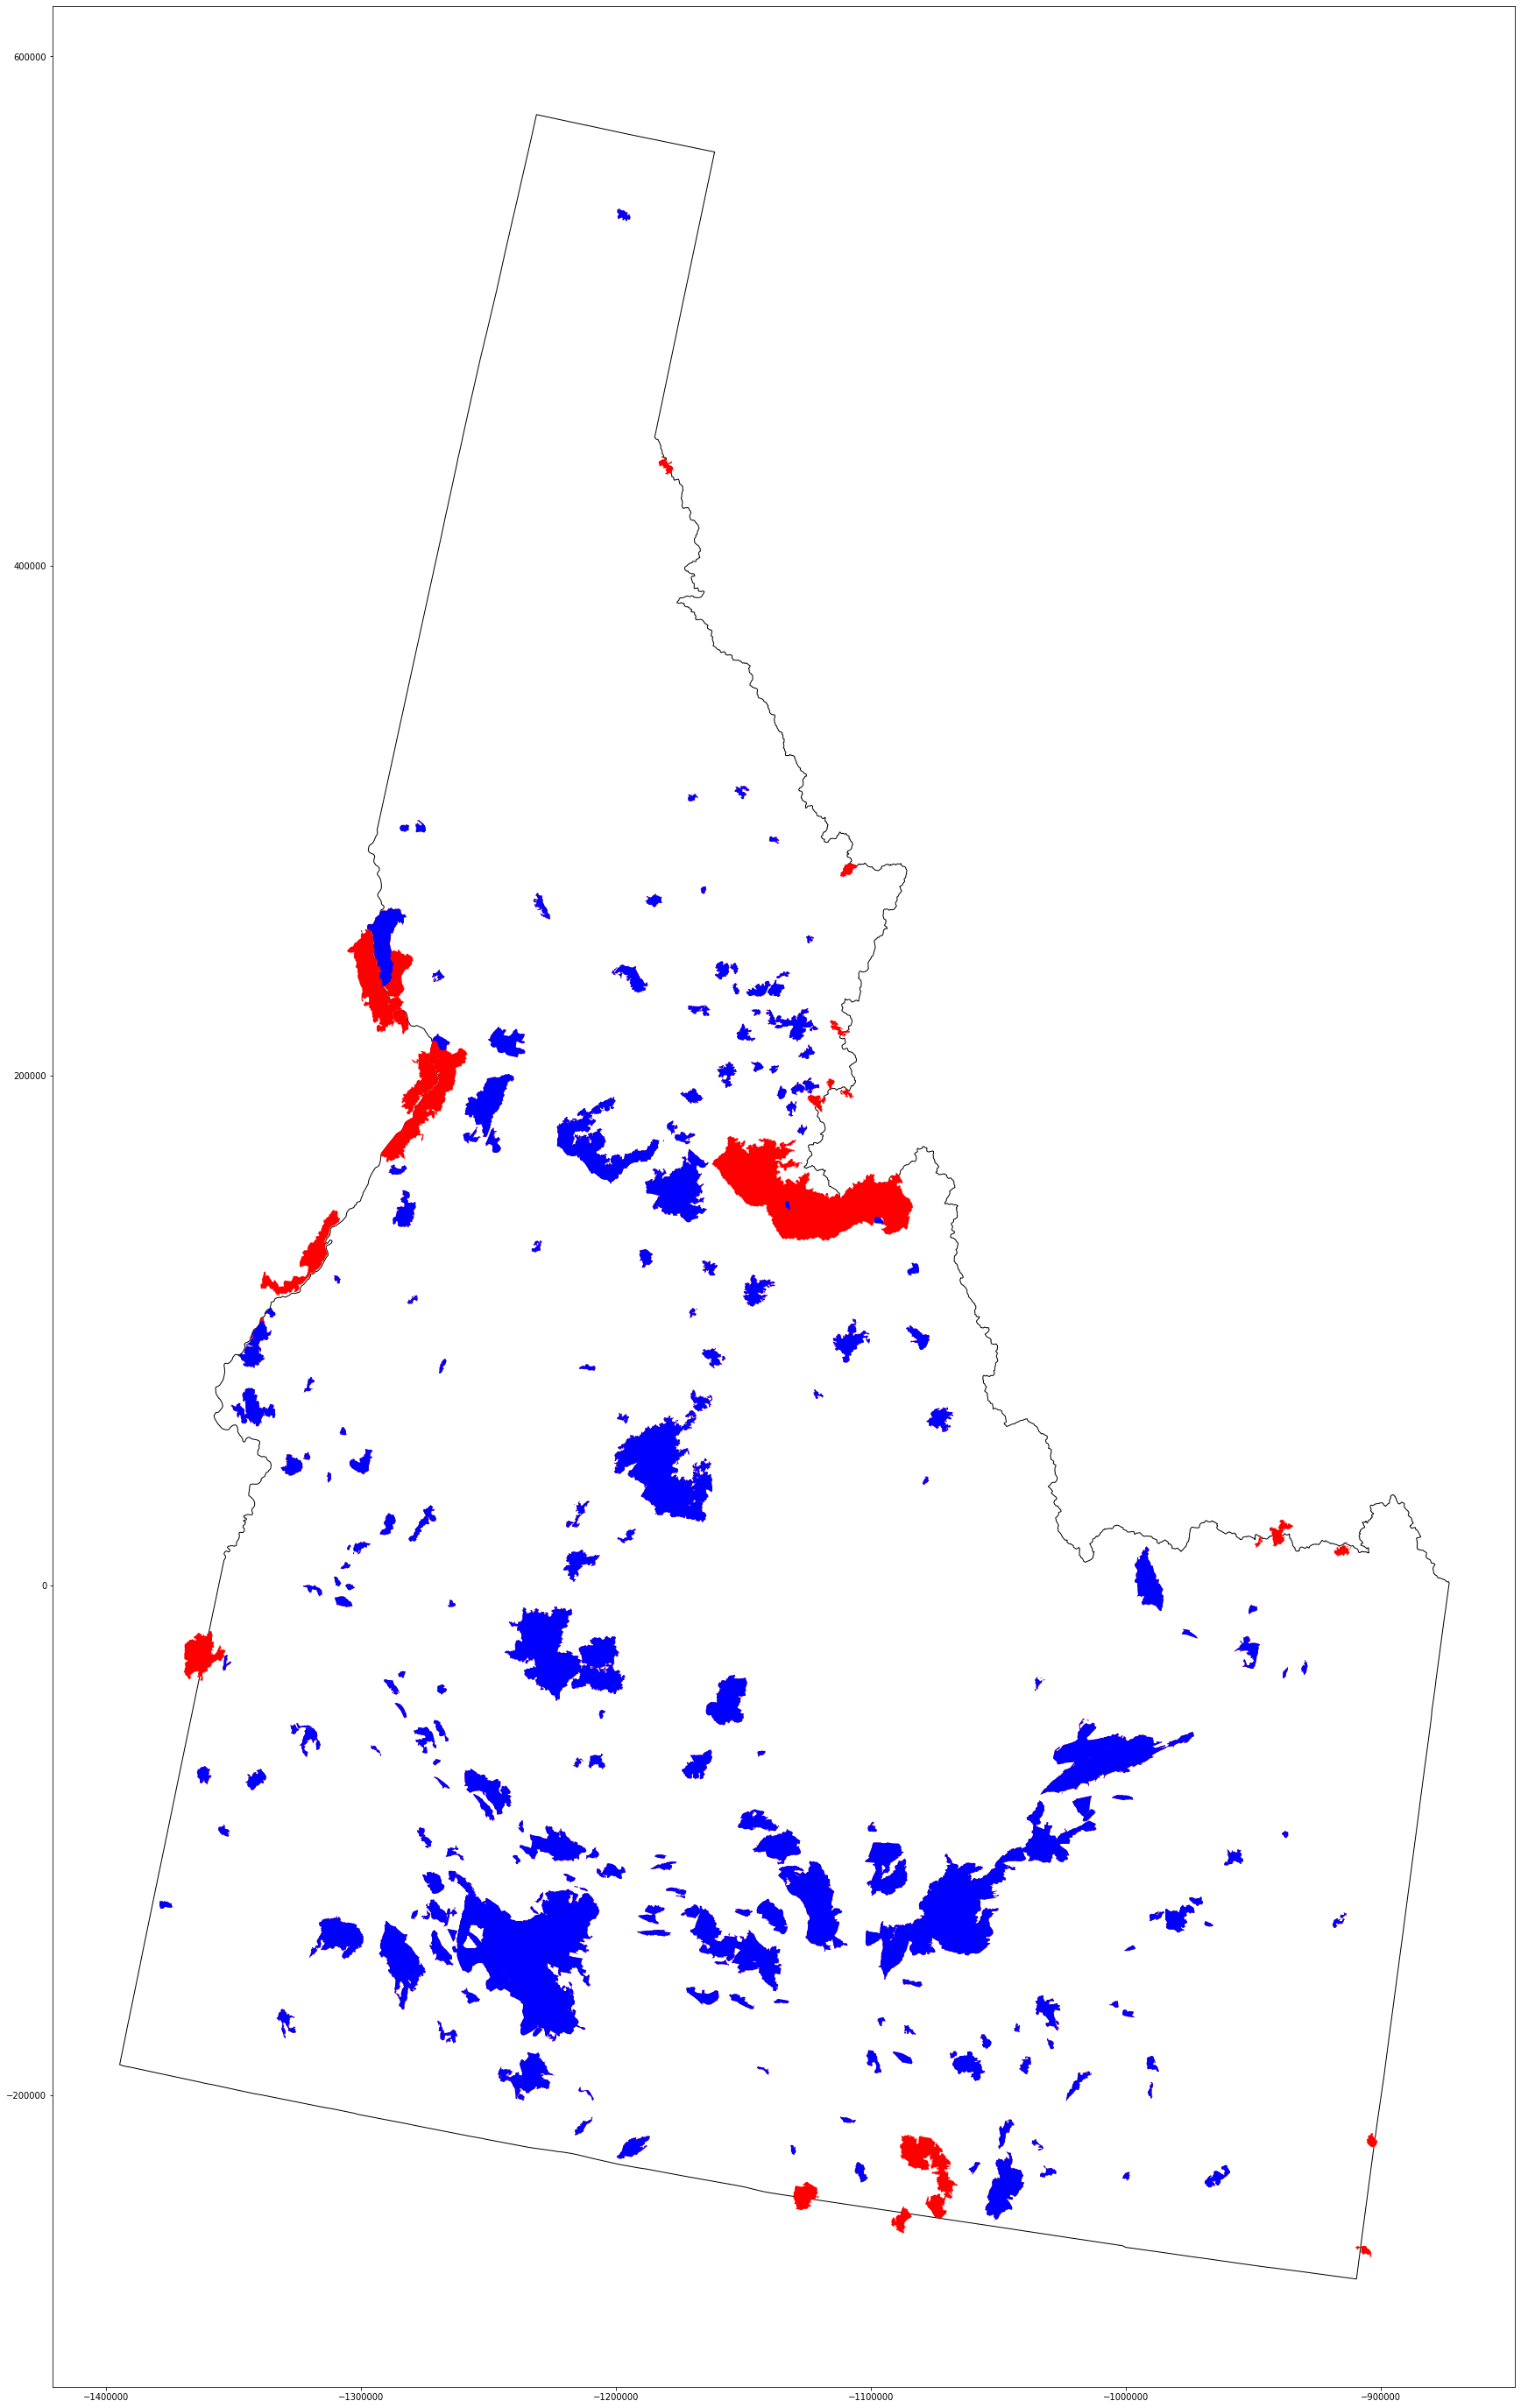

In [39]:
## Graph within (completely in Idaho) and intersect (fires that touch Idaho)
basemap = WestStatesMap_proj.loc[WestStatesMap_proj['STUSPS']=='ID'].plot(edgecolor = 'black', color='white')
ID_fires_intersect.plot(ax=basemap, color='red')
ID_fires_within.plot(ax=basemap, color = 'blue')

# Grab Zillow Data

In [40]:
## Go to Zillow Data (unzipped)

## Set Directory
Zillowpath = '/data/yoder/ZillowAccessor_2001_2014/'
os.chdir(Zillowpath)
# os.listdir()
# Create Dictionary for State Abbreviations and Zillow numbers

States = {}
for p in glob.glob(Zillowpath+'*'):  
    try:
        df = pd.read_csv(p+'/ZAsmt\Main.txt', delimiter="|", header=None, nrows=100)
        States[p] = df.iloc[0,3]
#         print(p)
    except:
#         print("failed")
        pass
        
st = {value:key for key, value in States.items()}
dict(sorted(st.items()))

{'AK': '/data/yoder/ZillowAccessor_2001_2014/02',
 'AL': '/data/yoder/ZillowAccessor_2001_2014/01',
 'AR': '/data/yoder/ZillowAccessor_2001_2014/05',
 'AZ': '/data/yoder/ZillowAccessor_2001_2014/04',
 'CA': '/data/yoder/ZillowAccessor_2001_2014/06',
 'CO': '/data/yoder/ZillowAccessor_2001_2014/08',
 'CT': '/data/yoder/ZillowAccessor_2001_2014/09',
 'DC': '/data/yoder/ZillowAccessor_2001_2014/11',
 'DE': '/data/yoder/ZillowAccessor_2001_2014/10',
 'FL': '/data/yoder/ZillowAccessor_2001_2014/12',
 'GA': '/data/yoder/ZillowAccessor_2001_2014/13',
 'GU': '/data/yoder/ZillowAccessor_2001_2014/66',
 'HI': '/data/yoder/ZillowAccessor_2001_2014/15',
 'IA': '/data/yoder/ZillowAccessor_2001_2014/19',
 'ID': '/data/yoder/ZillowAccessor_2001_2014/16',
 'IL': '/data/yoder/ZillowAccessor_2001_2014/17',
 'IN': '/data/yoder/ZillowAccessor_2001_2014/18',
 'KS': '/data/yoder/ZillowAccessor_2001_2014/20',
 'KY': '/data/yoder/ZillowAccessor_2001_2014/21',
 'LA': '/data/yoder/ZillowAccessor_2001_2014/22',


In [41]:
## Select only Western States
West = ['WA', 'OR', 'CA', 'NV','AZ','NM', 'UT','CO','WY','ID','MT']
WestStatesList = [st[x] for x in st if x in West]
WestStatesDict = {x:st[x] for x in West}
WestStatesDict

{'WA': '/data/yoder/ZillowAccessor_2001_2014/53',
 'OR': '/data/yoder/ZillowAccessor_2001_2014/41',
 'CA': '/data/yoder/ZillowAccessor_2001_2014/06',
 'NV': '/data/yoder/ZillowAccessor_2001_2014/32',
 'AZ': '/data/yoder/ZillowAccessor_2001_2014/04',
 'NM': '/data/yoder/ZillowAccessor_2001_2014/35',
 'UT': '/data/yoder/ZillowAccessor_2001_2014/49',
 'CO': '/data/yoder/ZillowAccessor_2001_2014/08',
 'WY': '/data/yoder/ZillowAccessor_2001_2014/56',
 'ID': '/data/yoder/ZillowAccessor_2001_2014/16',
 'MT': '/data/yoder/ZillowAccessor_2001_2014/30'}

In [42]:
## Grab Idaho (for now)
subpath = st['ID']
os.chdir(subpath)
os.listdir()

['ZAsmt\\Building.txt',
 'ZAsmt\\BuildingAreas.txt',
 'ZAsmt\\Garage.txt',
 'ZAsmt\\LotSiteAppeal.txt',
 'ZAsmt\\Main.txt',
 'ZAsmt\\Value.txt',
 'ID_sample',
 'ID_all',
 'ID_latLongsonly.csv',
 'ID_ZillowRows_to_POO_and_perim.csv']

In [43]:
# ####  Load dataframes for each state:
start=time.time()
Frames=[]

Main=pd.read_csv("ZAsmt\\Main.txt", sep="|", header=None) #, encoding='latin1')
print("Loaded Main")

# end = time.time()
# print(end-start)


# Building=pd.read_csv("ZAsmt\\Building.txt", sep="|", header=None)
# print("Loaded Building")
# BuildingAreas=pd.read_csv("ZAsmt\\BuildingAreas.txt", sep="|", header=None)
# print("Loaded Building Areas")
# Garage=pd.read_csv("ZAsmt\\Garage.txt", sep= "|", header=None)
# print("Loaded Garage")
# LotSiteAppeal=pd.read_csv("ZAsmt\\LotSiteAppeal.txt", sep="|", header=None)
# print("Loaded LotSiteAppeal")
# Value=pd.rea
# value=pd.read_csv("ZAsmt\\Value.txt", sep="|", header=None)
# print("LoadLed Value")

## Label columns using excel table with list of columnn names
def NameCols(dataframe, dictname):
    xls=pd.ExcelFile(f'/data/yoder/ZillowAccessor_2001_2014/ZAsmt_dicts/{dictname}.xlsx')
    df=xls.parse(xls.sheet_names[0])
    df.to_dict()
    dataframe.columns = dataframe.columns.to_series().map(df['FieldName'])
    

NameCols(Main, 'utMain')   

# end2=time.time()
# print(end2-end)
# NameCols(Building, 'utBuilding')
# NameCols(BuildingAreas, 'utBuildingArea')
# NameCols(Garage, 'utGarage')
# NameCols(Value, 'utValue')
# NameCols(LotSiteAppeal,'utLotSiteAppeal')

/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,10,13,14,15,20,25,29,30,34,37,44,45,46,47,50,52,53,54,55,56,59,65,67,73,74,77,78,83) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loaded Main


NameError: name 'end2' is not defined

In [38]:
## Merge Zillow Files for that state together

All = Main

# All=pd.merge(Main, Building, on='RowID')
# All=pd.merge(All, BuildingAreas, on='RowID')
# All=pd.merge(All, Garage, on='RowID')
# All=pd.merge(All, Value, on='RowID')

In [39]:
## For Idaho
start = time.time()

ID = geopandas.GeoDataFrame(All, geometry=geopandas.points_from_xy(All.PropertyAddressLongitude, All.PropertyAddressLatitude))

end=time.time()
print(end-start)

38.224671363830566


In [40]:
# Assign Zillow's crs to Zillow data then transform to North American Equal area 2163


ID_proj = ID.copy()
ID_proj.crs="epsg:4326"
ID_proj=ID_proj.to_crs("EPSG:2163")
ID_proj.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [41]:
ID_proj.memory_usage().sum()/1000000000

2.819078528

In [42]:
# Create df with only Zillow RowID and geometry vars
ID_proj_selection = ID_proj[['RowID', 'geometry']].copy()
ID_proj_selection

RowID                         geometry
0        4D27FB96-33D5-E511-80C1-3863BB43AC67  POINT (-1250236.861 393334.225)
1        4E27FB96-33D5-E511-80C1-3863BB43AC67  POINT (-1250243.579 393329.032)
2        4F27FB96-33D5-E511-80C1-3863BB43AC67  POINT (-1250259.292 393316.618)
3        5027FB96-33D5-E511-80C1-3863BB43AC67  POINT (-1250272.751 393306.122)
4        5127FB96-33D5-E511-80C1-3863BB43AC67  POINT (-1250364.911 393258.847)
...                                       ...                              ...
3670670  8854D525-D3D5-E511-80C1-3863BB43AC67  POINT (-1283858.170 -62224.281)
3670671  8A54D525-D3D5-E511-80C1-3863BB43AC67  POINT (-1284950.836 -61454.189)
3670672  8B54D525-D3D5-E511-80C1-3863BB43AC67  POINT (-1284243.042 -62052.369)
3670673  8D54D525-D3D5-E511-80C1-3863BB43AC67  POINT (-1281720.995 -69289.428)
3670674  8F54D525-D3D5-E511-80C1-3863BB43AC67                  POINT (nan nan)

[3670675 rows x 2 columns]

In [43]:
# ID_fires_intersect

In [44]:
# Create buffer zone around fires contained in Idaho

Idaho_fires_30km = ID_fires_within.copy()
Idaho_fires_30km['geometry_perimeter'] = Idaho_fires_30km['geometry'].copy()
Idaho_fires_30km['geometry'] = Idaho_fires_30km.buffer(30000)

# # plot fires and buffe
# base = WestStatesMap_proj.loc[WestStatesMap_proj['STUSPS']=='ID'].plot(color = 'white', edgecolor = 'black')
# Idaho_fires_30km.plot(ax = base, color = 'blue')
# ID_fires_within.plot(ax = base, color = 'red')


# Keep only geographic variables for fires
Idaho_fires_30km_selection = Idaho_fires_30km[['Fire_ID', 'POO_LONGITUDE','POO_LATITUDE','geometry', 'geometry_perimeter']].copy()


In [45]:
## Merge Idaho structures with fires within 30km (takes 654 sec for intersects 429 sec for within )
start = time.time()

Fires_with_homes_30km_selection = geopandas.sjoin(ID_proj_selection, Idaho_fires_30km_selection, how ='inner', op='intersects')

end =time.time()
print(end-start)

490.98560214042664


In [46]:
## For troubleshooting row 11 is the same
# ID_proj_selection.head(12)

In [47]:
# Fires_with_homes_30km_selection.head(10)

In [48]:
## Save and clear structure point geometry to save point of origin geometry

Fires_with_homes_30km_selection['geometry_structure'] = Fires_with_homes_30km_selection['geometry'].copy()
Fires_with_homes_30km_selection.drop(['geometry'], axis=1)

RowID  index_right  \
11       6A46AE77-3DD5-E511-80C1-3863BB43AC67         1278   
12       6B46AE77-3DD5-E511-80C1-3863BB43AC67         1278   
14       6D46AE77-3DD5-E511-80C1-3863BB43AC67         1278   
15       6E46AE77-3DD5-E511-80C1-3863BB43AC67         1278   
16       6F46AE77-3DD5-E511-80C1-3863BB43AC67         1278   
...                                       ...          ...   
2203890  63597D79-C6D5-E511-80C1-3863BB43AC67          923   
2248659  332AC483-CFD5-E511-80C1-3863BB43AC67          923   
2265093  CB219184-CFD5-E511-80C1-3863BB43AC67          923   
2265376  8C229184-CFD5-E511-80C1-3863BB43AC67          923   
2284348  18419184-CFD5-E511-80C1-3863BB43AC67          923   

                       Fire_ID  POO_LONGITUDE  POO_LATITUDE  \
11       ID4483811636920030809    -116.380833     44.824444   
12       ID4483811636920030809    -116.380833     44.824444   
14       ID4483811636920030809    -116.380833     44.824444   
15       ID4483811636920030809    -116.380833     44.824444   
16       ID4483811636920030809    -116.380833     44.824444   
...                        ...            ...           ...   
2203890  ID4222211515020060930    -115.121389     42.217778   
2248659  ID4222211515020060930    -115.121389     42.217778   
2265093  ID4222211515020060930    -115.121389     42.217778   
2265376  ID4222211515020060930    -115.121389     42.217778   
2284348  ID4222211515020060930    -115.121389     42.217778   

                                        geometry_perimeter  \
11       POLYGON ((-1281117.851 111636.667, -1281111.16...   
12       POLYGON ((-1281117.851 111636.667, -1281111.16...   
14       POLYGON ((-1281117.851 111636.667, -1281111.16...   
15       POLYGON ((-1281117.851 111636.667, -1281111.16...   
16       POLYGON ((-1281117.851 111636.667, -1281111.16...   
...                                                    ...   
2203890  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2248659  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2265093  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2265376  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2284348  POLYGON ((-1239777.156 -192162.065, -1239735.2...   

                       geometry_structure  
11        POINT (-1279350.064 120210.524)  
12        POINT (-1300947.803 122517.430)  
14        POINT (-1293953.821 114582.927)  
15        POINT (-1293953.821 114582.927)  
16         POINT (-1289975.134 90369.496)  
...                                   ...  
2203890  POINT (-1214823.708 -201440.341)  
2248659  POINT (-1214839.853 -201437.366)  
2265093  POINT (-1216719.800 -178890.835)  
2265376  POINT (-1229951.163 -204765.657)  
2284348  POINT (-1214839.853 -201437.366)  

[16804428 rows x 7 columns]

In [49]:
start = time.time()

In [82]:
## Assign point of origin to geometry to calculate distance from structure to point of origin for each fire within range (creating gdf takes 175 sec)
Merged_30km = geopandas.GeoDataFrame(Fires_with_homes_30km_selection, geometry=geopandas.points_from_xy(Fires_with_homes_30km_selection.POO_LONGITUDE , Fires_with_homes_30km_selection.POO_LATITUDE))

In [83]:
## Assign crs and apply projection (changing crs takes ~14 min )
Merged_30km.crs="epsg:4326"
Merged_30km = Merged_30km.to_crs("EPSG:2163")

In [84]:
Merged_30km.head(10)

RowID                         geometry  \
11  6A46AE77-3DD5-E511-80C1-3863BB43AC67  POINT (-1280919.726 110744.463)   
12  6B46AE77-3DD5-E511-80C1-3863BB43AC67  POINT (-1280919.726 110744.463)   
14  6D46AE77-3DD5-E511-80C1-3863BB43AC67  POINT (-1280919.726 110744.463)   
15  6E46AE77-3DD5-E511-80C1-3863BB43AC67  POINT (-1280919.726 110744.463)   
16  6F46AE77-3DD5-E511-80C1-3863BB43AC67  POINT (-1280919.726 110744.463)   
17  7046AE77-3DD5-E511-80C1-3863BB43AC67  POINT (-1280919.726 110744.463)   
18  7146AE77-3DD5-E511-80C1-3863BB43AC67  POINT (-1280919.726 110744.463)   
19  7246AE77-3DD5-E511-80C1-3863BB43AC67  POINT (-1280919.726 110744.463)   
52  7346AE77-3DD5-E511-80C1-3863BB43AC67  POINT (-1280919.726 110744.463)   
53  7446AE77-3DD5-E511-80C1-3863BB43AC67  POINT (-1280919.726 110744.463)   

    index_right                Fire_ID  POO_LONGITUDE  POO_LATITUDE  \
11         1278  ID4483811636920030809    -116.380833     44.824444   
12         1278  ID4483811636920030809    -116.380833     44.824444   
14         1278  ID4483811636920030809    -116.380833     44.824444   
15         1278  ID4483811636920030809    -116.380833     44.824444   
16         1278  ID4483811636920030809    -116.380833     44.824444   
17         1278  ID4483811636920030809    -116.380833     44.824444   
18         1278  ID4483811636920030809    -116.380833     44.824444   
19         1278  ID4483811636920030809    -116.380833     44.824444   
52         1278  ID4483811636920030809    -116.380833     44.824444   
53         1278  ID4483811636920030809    -116.380833     44.824444   

                                   geometry_perimeter  \
11  POLYGON ((-1281117.851 111636.667, -1281111.16...   
12  POLYGON ((-1281117.851 111636.667, -1281111.16...   
14  POLYGON ((-1281117.851 111636.667, -1281111.16...   
15  POLYGON ((-1281117.851 111636.667, -1281111.16...   
16  POLYGON ((-1281117.851 111636.667, -1281111.16...   
17  POLYGON ((-1281117.851 111636.667, -1281111.16...   
18  POLYGON ((-1281117.851 111636.667, -1281111.16...   
19  POLYGON ((-1281117.851 111636.667, -1281111.16...   
52  POLYGON ((-1281117.851 111636.667, -1281111.16...   
53  POLYGON ((-1281117.851 111636.667, -1281111.16...   

                 geometry_structure  
11  POINT (-1279350.064 120210.524)  
12  POINT (-1300947.803 122517.430)  
14  POINT (-1293953.821 114582.927)  
15  POINT (-1293953.821 114582.927)  
16   POINT (-1289975.134 90369.496)  
17   POINT (-1290992.069 90170.927)  
18   POINT (-1290992.069 90170.927)  
19   POINT (-1291038.669 90178.080)  
52   POINT (-1290656.445 90126.445)  
53   POINT (-1290491.576 90073.892)

In [85]:
Merged_30km['geometry_origin']=Merged_30km['geometry'].copy()

# Everything above this runs fine
it takes 50 min to complete

In [ ]:
## Plot fires and projection
# base = Idaho_boundry_proj.plot(color = 'white', edgecolor = 'black')
# Idaho_fires_proj.plot(ax = base, color = 'red')
# Merged_30km.plot(ax = base, color = 'blue')

In [86]:
Merged_30km['geometry'] = Merged_30km['geometry_structure'].copy()

In [98]:
Merged_30km['geometry'] = Merged_30km['geometry_origin'].copy()

In [91]:
Merged_30km

RowID  \
11       6A46AE77-3DD5-E511-80C1-3863BB43AC67   
12       6B46AE77-3DD5-E511-80C1-3863BB43AC67   
14       6D46AE77-3DD5-E511-80C1-3863BB43AC67   
15       6E46AE77-3DD5-E511-80C1-3863BB43AC67   
16       6F46AE77-3DD5-E511-80C1-3863BB43AC67   
...                                       ...   
2203890  63597D79-C6D5-E511-80C1-3863BB43AC67   
2248659  332AC483-CFD5-E511-80C1-3863BB43AC67   
2265093  CB219184-CFD5-E511-80C1-3863BB43AC67   
2265376  8C229184-CFD5-E511-80C1-3863BB43AC67   
2284348  18419184-CFD5-E511-80C1-3863BB43AC67   

                                 geometry  index_right                Fire_ID  \
11        POINT (-1280919.726 110744.463)         1278  ID4483811636920030809   
12        POINT (-1280919.726 110744.463)         1278  ID4483811636920030809   
14        POINT (-1280919.726 110744.463)         1278  ID4483811636920030809   
15        POINT (-1280919.726 110744.463)         1278  ID4483811636920030809   
16        POINT (-1280919.726 110744.463)         1278  ID4483811636920030809   
...                                   ...          ...                    ...   
2203890  POINT (-1236833.848 -194668.689)          923  ID4222211515020060930   
2248659  POINT (-1236833.848 -194668.689)          923  ID4222211515020060930   
2265093  POINT (-1236833.848 -194668.689)          923  ID4222211515020060930   
2265376  POINT (-1236833.848 -194668.689)          923  ID4222211515020060930   
2284348  POINT (-1236833.848 -194668.689)          923  ID4222211515020060930   

         POO_LONGITUDE  POO_LATITUDE  \
11         -116.380833     44.824444   
12         -116.380833     44.824444   
14         -116.380833     44.824444   
15         -116.380833     44.824444   
16         -116.380833     44.824444   
...                ...           ...   
2203890    -115.121389     42.217778   
2248659    -115.121389     42.217778   
2265093    -115.121389     42.217778   
2265376    -115.121389     42.217778   
2284348    -115.121389     42.217778   

                                        geometry_perimeter  \
11       POLYGON ((-1281117.851 111636.667, -1281111.16...   
12       POLYGON ((-1281117.851 111636.667, -1281111.16...   
14       POLYGON ((-1281117.851 111636.667, -1281111.16...   
15       POLYGON ((-1281117.851 111636.667, -1281111.16...   
16       POLYGON ((-1281117.851 111636.667, -1281111.16...   
...                                                    ...   
2203890  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2248659  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2265093  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2265376  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2284348  POLYGON ((-1239777.156 -192162.065, -1239735.2...   

                       geometry_structure                   geometry_origin  
11        POINT (-1279350.064 120210.524)   POINT (-1280919.726 110744.463)  
12        POINT (-1300947.803 122517.430)   POINT (-1280919.726 110744.463)  
14        POINT (-1293953.821 114582.927)   POINT (-1280919.726 110744.463)  
15        POINT (-1293953.821 114582.927)   POINT (-1280919.726 110744.463)  
16         POINT (-1289975.134 90369.496)   POINT (-1280919.726 110744.463)  
...                                   ...                               ...  
2203890  POINT (-1214823.708 -201440.341)  POINT (-1236833.848 -194668.689)  
2248659  POINT (-1214839.853 -201437.366)  POINT (-1236833.848 -194668.689)  
2265093  POINT (-1216719.800 -178890.835)  POINT (-1236833.848 -194668.689)  
2265376  POINT (-1229951.163 -204765.657)  POINT (-1236833.848 -194668.689)  
2284348  POINT (-1214839.853 -201437.366)  POINT (-1236833.848 -194668.689)  

[16804428 rows x 9 columns]

In [92]:
start = time.time()

In [93]:
## Define and run function to get distance from origin to structure (takes 1909 sec)
def get_distance(row):
    distance = row.geometry.distance(row.geometry_structure)
    return distance

Merged_30km['Origin_to_structure_projected'] = Merged_30km.apply(lambda row: get_distance(row), axis = 1)

In [94]:
end = time.time()
print(end-start)

1909.051070690155


In [95]:
## Check distance from structure to perimeter
Merged_30km['Origin_to_structure_projected'].describe()/1000

count    16804.428000
mean        23.761286
std          7.892590
min          0.032689
25%         18.914122
50%         24.447934
75%         28.697550
max         94.113733
Name: Origin_to_structure_projected, dtype: float64

In [105]:
Merged_30km['geometry'] =Merged_30km['geometry_structure'].copy()

In [106]:
Merged_30km

RowID  \
11       6A46AE77-3DD5-E511-80C1-3863BB43AC67   
12       6B46AE77-3DD5-E511-80C1-3863BB43AC67   
14       6D46AE77-3DD5-E511-80C1-3863BB43AC67   
15       6E46AE77-3DD5-E511-80C1-3863BB43AC67   
16       6F46AE77-3DD5-E511-80C1-3863BB43AC67   
...                                       ...   
2203890  63597D79-C6D5-E511-80C1-3863BB43AC67   
2248659  332AC483-CFD5-E511-80C1-3863BB43AC67   
2265093  CB219184-CFD5-E511-80C1-3863BB43AC67   
2265376  8C229184-CFD5-E511-80C1-3863BB43AC67   
2284348  18419184-CFD5-E511-80C1-3863BB43AC67   

                                 geometry  index_right                Fire_ID  \
11        POINT (-1279350.064 120210.524)         1278  ID4483811636920030809   
12        POINT (-1300947.803 122517.430)         1278  ID4483811636920030809   
14        POINT (-1293953.821 114582.927)         1278  ID4483811636920030809   
15        POINT (-1293953.821 114582.927)         1278  ID4483811636920030809   
16         POINT (-1289975.134 90369.496)         1278  ID4483811636920030809   
...                                   ...          ...                    ...   
2203890  POINT (-1214823.708 -201440.341)          923  ID4222211515020060930   
2248659  POINT (-1214839.853 -201437.366)          923  ID4222211515020060930   
2265093  POINT (-1216719.800 -178890.835)          923  ID4222211515020060930   
2265376  POINT (-1229951.163 -204765.657)          923  ID4222211515020060930   
2284348  POINT (-1214839.853 -201437.366)          923  ID4222211515020060930   

         POO_LONGITUDE  POO_LATITUDE  \
11         -116.380833     44.824444   
12         -116.380833     44.824444   
14         -116.380833     44.824444   
15         -116.380833     44.824444   
16         -116.380833     44.824444   
...                ...           ...   
2203890    -115.121389     42.217778   
2248659    -115.121389     42.217778   
2265093    -115.121389     42.217778   
2265376    -115.121389     42.217778   
2284348    -115.121389     42.217778   

                                        geometry_perimeter  \
11       POLYGON ((-1281117.851 111636.667, -1281111.16...   
12       POLYGON ((-1281117.851 111636.667, -1281111.16...   
14       POLYGON ((-1281117.851 111636.667, -1281111.16...   
15       POLYGON ((-1281117.851 111636.667, -1281111.16...   
16       POLYGON ((-1281117.851 111636.667, -1281111.16...   
...                                                    ...   
2203890  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2248659  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2265093  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2265376  POLYGON ((-1239777.156 -192162.065, -1239735.2...   
2284348  POLYGON ((-1239777.156 -192162.065, -1239735.2...   

                       geometry_structure                   geometry_origin  \
11        POINT (-1279350.064 120210.524)   POINT (-1280919.726 110744.463)   
12        POINT (-1300947.803 122517.430)   POINT (-1280919.726 110744.463)   
14        POINT (-1293953.821 114582.927)   POINT (-1280919.726 110744.463)   
15        POINT (-1293953.821 114582.927)   POINT (-1280919.726 110744.463)   
16         POINT (-1289975.134 90369.496)   POINT (-1280919.726 110744.463)   
...                                   ...                               ...   
2203890  POINT (-1214823.708 -201440.341)  POINT (-1236833.848 -194668.689)   
2248659  POINT (-1214839.853 -201437.366)  POINT (-1236833.848 -194668.689)   
2265093  POINT (-1216719.800 -178890.835)  POINT (-1236833.848 -194668.689)   
2265376  POINT (-1229951.163 -204765.657)  POINT (-1236833.848 -194668.689)   
2284348  POINT (-1214839.853 -201437.366)  POINT (-1236833.848 -194668.689)   

         Origin_to_structure_projected  
11                         9595.318918  
12                        23232.016790  
14                        13587.547083  
15                        13587.547083  
16                        22296.630142  
...                                ...  
2203890         

In [107]:
start = time.time()

In [108]:
## takes about 50 min

def get_distance(row):
    distance = row.geometry.distance(row.geometry_perimeter)
#     print(distance)
    return distance

Merged_30km['Structure_to_perim'] = Merged_30km.apply(lambda row: get_distance(row), axis = 1)

In [109]:
end = time.time()
print(end-start)

2953.2570407390594


In [114]:
Merged_30km['Structure_to_perim']

11          6457.539392
12         22193.770670
14         12574.098755
15         12574.098755
16         21814.602896
               ...     
2203890    22267.966313
2248659    22251.610364
2265093    24268.716893
2265376    11197.941680
2284348    22251.610364
Name: Structure_to_perim, Length: 16804428, dtype: float64

In [116]:
ID_ZillowRows_to_POO_and_perim = Merged_30km[['RowID','Fire_ID','Origin_to_structure_projected','Structure_to_perim','geometry_structure','geometry_origin']].copy()

In [117]:
# start = time.time()
# ## Save as csv
# ## Saving takes 15 min loading takes 1 min

# ID_ZillowRows_to_POO_and_perim.to_csv('ID_ZillowRows_to_POO_and_perim.csv')

# end=time.time()
# print(end-start)

888.2930917739868


In [20]:
import os
import time
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import logit
from statsmodels.discrete.discrete_model import Probit


os.chdir('/data/yoder/ZillowAccessor_2001_2014/16')
os.listdir()

['ZAsmt\\Building.txt',
 'ZAsmt\\BuildingAreas.txt',
 'ZAsmt\\Garage.txt',
 'ZAsmt\\LotSiteAppeal.txt',
 'ZAsmt\\Main.txt',
 'ZAsmt\\Value.txt',
 'ID_sample',
 'ID_all',
 'ID_latLongsonly.csv',
 'ID_ZillowRows_to_POO_and_perim.csv']

In [22]:

ID_Zillow_matched = pd.read_csv('ID_ZillowRows_to_POO_and_perim.csv')

39.066970109939575


In [24]:
ID_Zillow_matched

Unnamed: 0                                 RowID  \
0                 11  6A46AE77-3DD5-E511-80C1-3863BB43AC67   
1                 12  6B46AE77-3DD5-E511-80C1-3863BB43AC67   
2                 14  6D46AE77-3DD5-E511-80C1-3863BB43AC67   
3                 15  6E46AE77-3DD5-E511-80C1-3863BB43AC67   
4                 16  6F46AE77-3DD5-E511-80C1-3863BB43AC67   
...              ...                                   ...   
16804423     2203890  63597D79-C6D5-E511-80C1-3863BB43AC67   
16804424     2248659  332AC483-CFD5-E511-80C1-3863BB43AC67   
16804425     2265093  CB219184-CFD5-E511-80C1-3863BB43AC67   
16804426     2265376  8C229184-CFD5-E511-80C1-3863BB43AC67   
16804427     2284348  18419184-CFD5-E511-80C1-3863BB43AC67   

                        Fire_ID  Origin_to_structure_projected  \
0         ID4483811636920030809                    9595.318918   
1         ID4483811636920030809                   23232.016790   
2         ID4483811636920030809                   13587.547083   
3         ID4483811636920030809                   13587.547083   
4         ID4483811636920030809                   22296.630142   
...                         ...                            ...   
16804423  ID4222211515020060930                   23028.277180   
16804424  ID4222211515020060930                   23011.971350   
16804425  ID4222211515020060930                   25563.951303   
16804426  ID4222211515020060930                   12219.661728   
16804427  ID4222211515020060930                   23011.971350   

          Structure_to_perim                             geometry_structure  \
0                6457.539392   POINT (-1279350.064368925 120210.5239881107)   
1               22193.770670   POINT (-1300947.802606555 122517.4299276362)   
2               12574.098755   POINT (-1293953.820938129 114582.9266140687)   
3               12574.098755   POINT (-1293953.820938129 114582.9266140687)   
4               21814.602896   POINT (-1289975.134397785 90369.49585011425)   
...                      ...                                            ...   
16804423        22267.966313  POINT (-1214823.708246317 -201440.3411855824)   
16804424        22251.610364  POINT (-1214839.853224796 -201437.3664682427)   
16804425        24268.716893    POINT (-1216719.79968961 -178890.835480897)   
16804426        11197.941680  POINT (-1229951.162785076 -204765.6570100457)   
16804427        22251.610364  POINT (-1214839.853224796 -201437.3664682427)   

                                        geometry_origin  
0          POINT (-1280919.725881522 110744.4631460915)  
1          POINT (-1280919.725881522 110744.4631460915)  
2          POINT (-1280919.725881522 110744.4631460915)  
3          POINT (-1280919.725881522 110744.4631460915)  
4          POINT (-1280919.725881522 110744.4631460915)  
...                                                 ...  
16804423  POINT (-1236833.848436972 -194668.6886054448)  
16804424  POINT (-1236833.848436972 -194668.6886054448)  
16804425  POINT (-1236833.848436972 -194668.6886054448)  
16804426  POINT (-1236833.848436972 -194668.6886054448)  
16804427  POINT (-1236833.848436972 -194668.6886054448)  

[16804428 rows x 7 columns]

In [25]:
ID = ID_Zillow_matched.copy()

In [26]:
ID['reached'] = np.where(ID['Structure_to_perim'] <= 0, 1, 0 )

In [29]:
Y = ID['reached']
X = ID['Origin_to_structure_projected']/1000
X = sm.add_constant(X)
model = Probit(Y, X.astype(float))
probit_model = model.fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.000568
         Iterations 26
                          Probit Regression Results                           
Dep. Variable:                reached   No. Observations:             16804428
Model:                         Probit   Df Residuals:                 16804426
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:                  0.3074
Time:                        00:18:10   Log-Likelihood:                -9549.4
converged:                       True   LL-Null:                       -13787.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.9321      0.018   -107.119      0

In [36]:
yhat = probit_model.predict(X)

In [46]:
prob = probit_model.predict_proba(X)

AttributeError: 'ProbitResults' object has no attribute 'predict_proba'

In [ ]:
prob.plot()

In [ ]:
import seaborn as sns
X = ID['Origin_to_structure_projected']/1000
sns.regplot(X, Y, data=ID, logistic=True , ci='none')


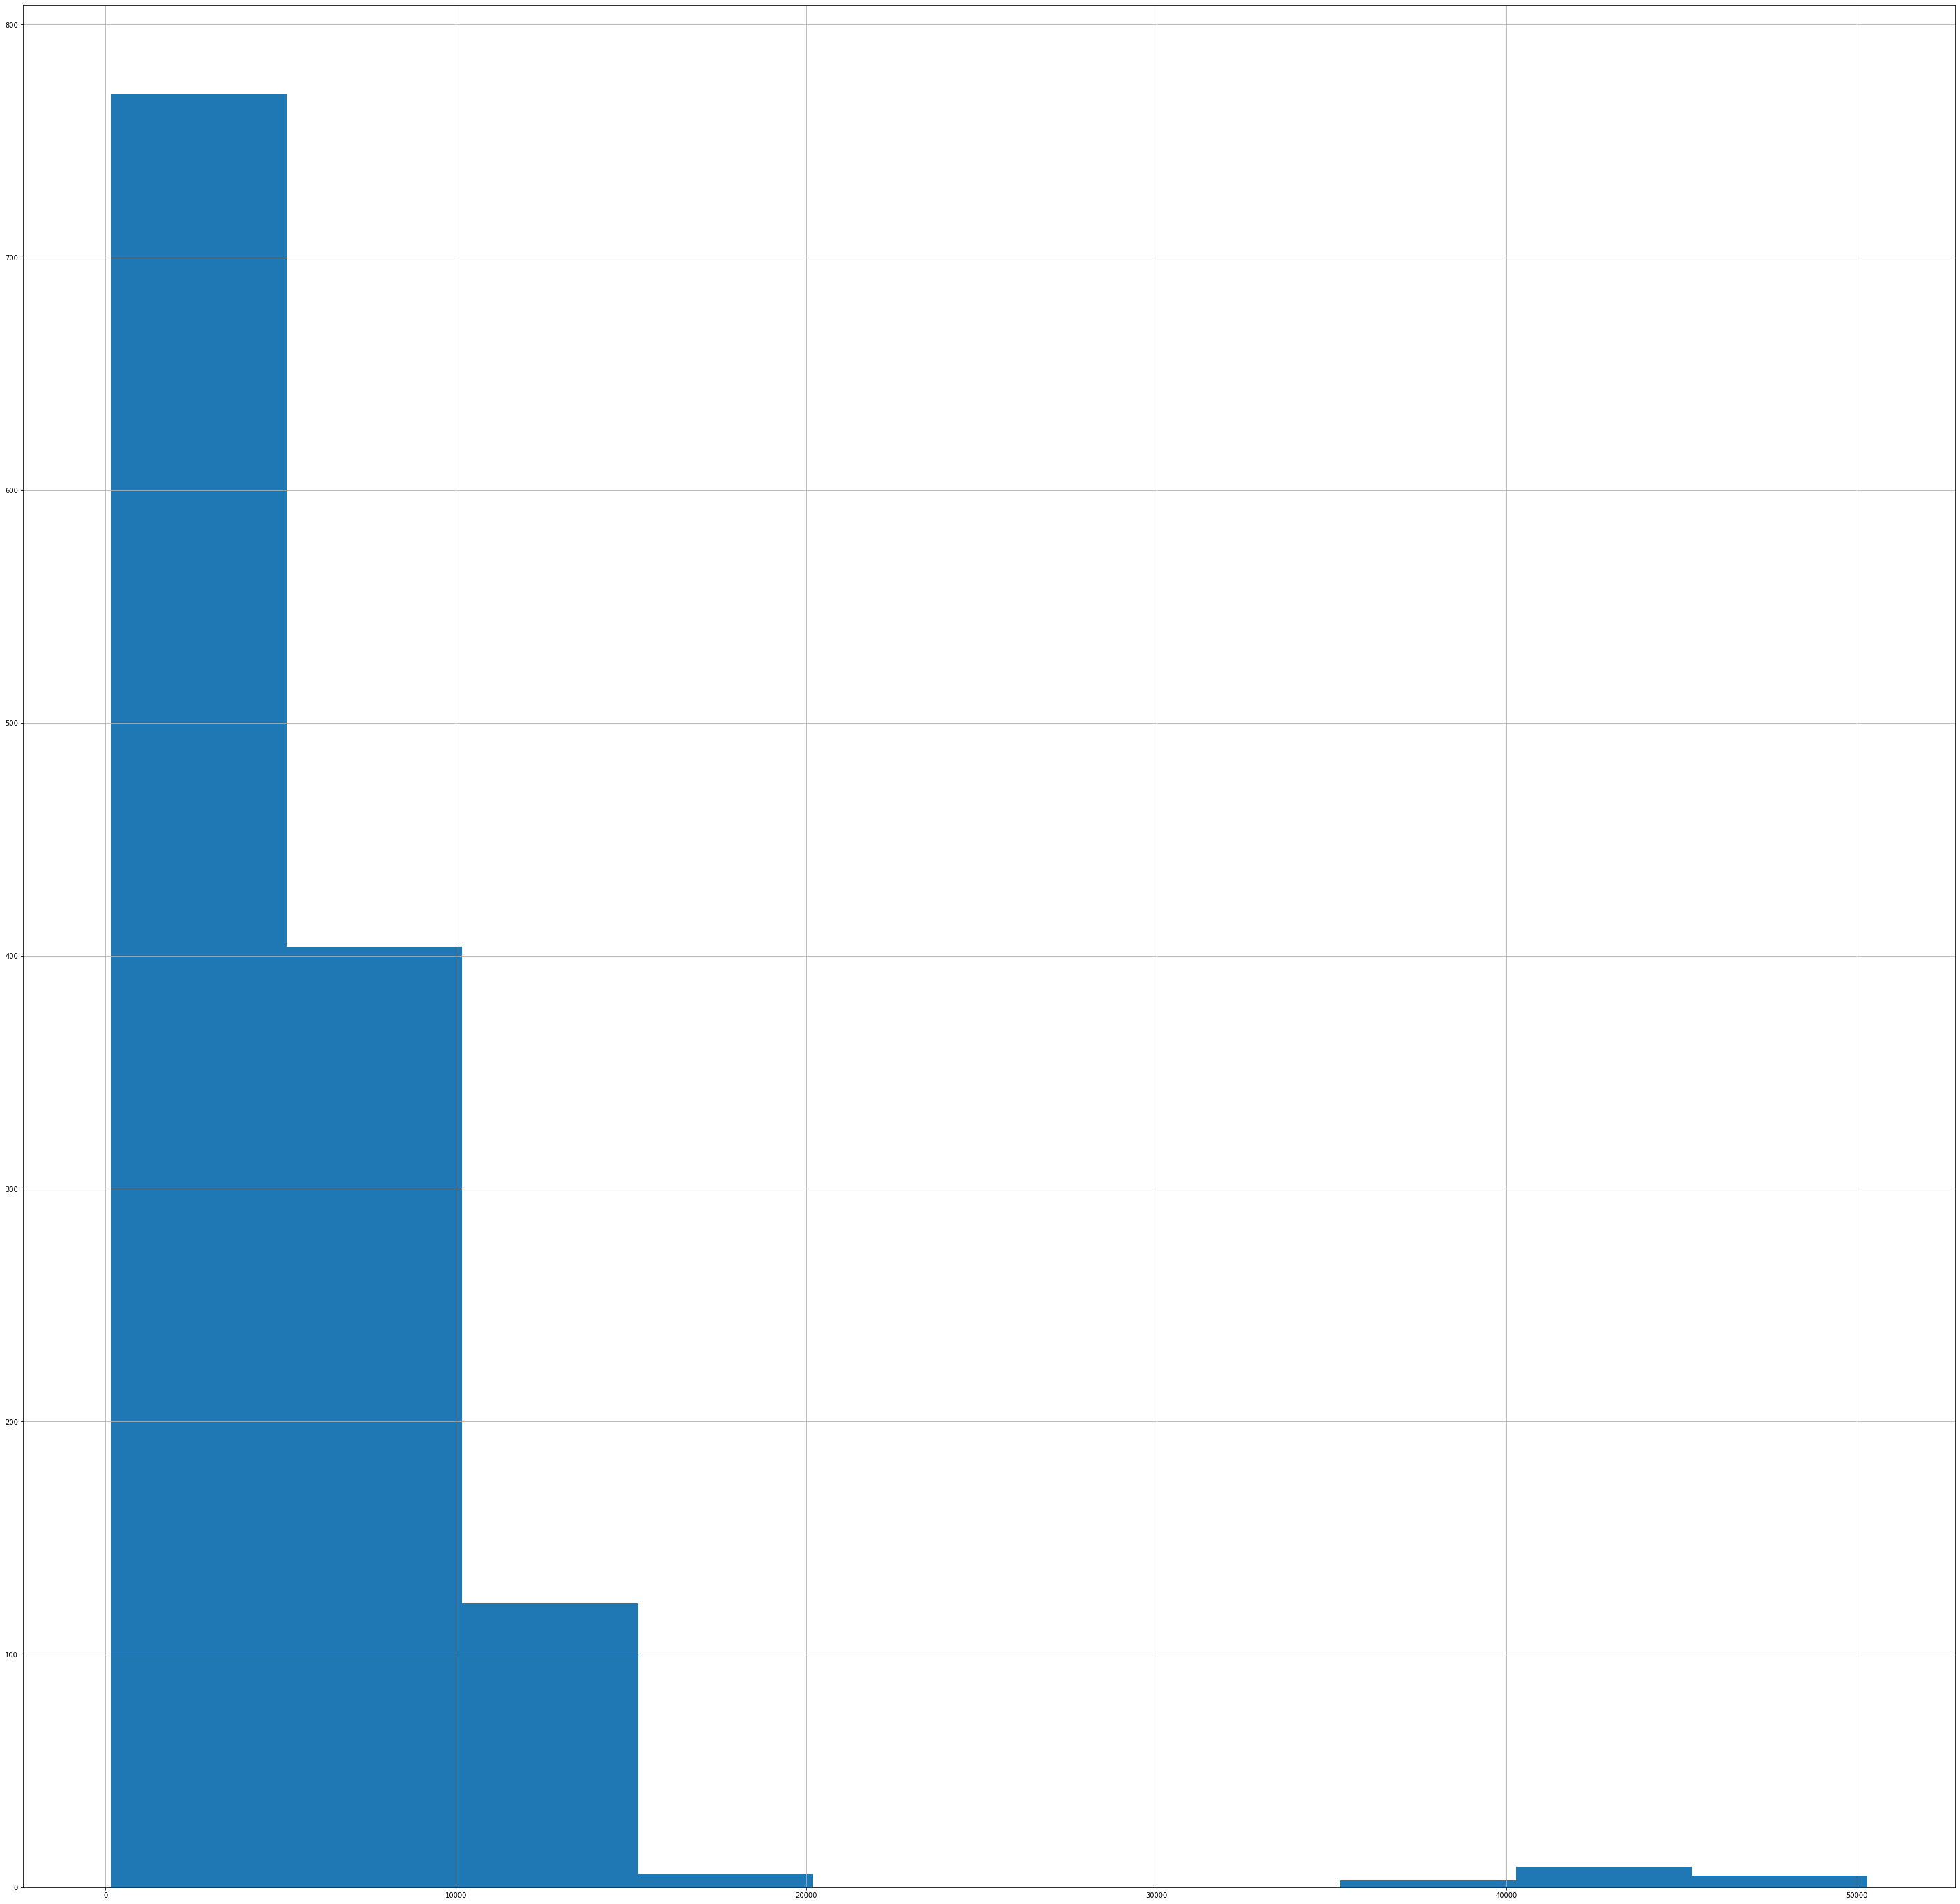

In [40]:
ID_reached['Origin_to_structure_projected'].hist()